In [204]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import plotly.express as px

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')

# Загружаем инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# для нормализации, стандартизации
from sklearn import preprocessing

# импортируем библиотеки для оценки значимости признаков
from sklearn.feature_selection import chi2 
from sklearn.feature_selection import f_classif

from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

import folium 
import ast
import category_encoders as ce
import time
import os, re

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# INPUT_DIR = '/kaggle/input/sf-booking/'
# INPUT_DIR = '../data/input/'
# INPUT_DIR = './data/input/'
INPUT_DIR = './data/'

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Professional\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [205]:
# фиксируем RANDOM_SEED
RANDOM_SEED = 42

# зафиксируем версию пакетов
!pip freeze > requirements.txt

## 1. Знакомство с данными

In [207]:
# подгружаем данные из соревнования

# датасет для обучения
hotels_train = pd.read_csv(INPUT_DIR + '/hotels_train.csv')

# датасет для предсказания
hotels_test = pd.read_csv(INPUT_DIR + 'hotels_test.csv')

# тестовый сабмишн
sample_submission = pd.read_csv(INPUT_DIR + '/submission.csv')

In [208]:
print('В датасете {} дубликатов в тренировочной выборке'.format(hotels_train[hotels_train.duplicated()].shape[0]))
hotels_train.drop_duplicates(inplace=True)
print('Количество строк после удаления дубликатов составляет: {}'.format(hotels_train.shape[0]))
print('В датасете {} дубликатов в тестовой выборке'.format(hotels_test[hotels_test.duplicated()].shape[0]))

В датасете 307 дубликатов в тренировочной выборке
Количество строк после удаления дубликатов составляет: 386496
В датасете 29 дубликатов в тестовой выборке


In [209]:
# чтобы не проводить двойные преобразования df_train и df_test, объединим эти два датасета, 
# а перед запуском обучения модели их разделим, для их различия введём новый признак 'sample'

# помечаем, где у нас трейн
hotels_train['sample'] = 1

# помечаем, где у нас тест
hotels_test['sample'] = 0

# в тесте у нас нет значения reviewer_score, мы его должны предсказать, поэтому пока просто заполняем нулями
hotels_test['reviewer_score'] = 0

# объединяем данные
hotels = pd.concat([hotels_test, hotels_train], sort=False).reset_index(drop=True)

# сверяемся с типом признаков
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

In [210]:
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0


## 2. Работа с признаками

In [211]:
# задаём маску для отбора тренировочных значений
# БУДЕТ ДЕЙСТВОВАТЬ НА ВСЕ РАСЧЁТЫ
sample_mask = hotels['sample']  == 1

In [212]:
# ищем в столбцах данные, содержащие пропущенные значения
print('В датасете следующие признаки имеют пропуски: {} '.format(hotels.isnull().sum()))

В датасете следующие признаки имеют пропуски: hotel_address                                    0
additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
negative_review                                  0
review_total_negative_word_counts                0
total_number_of_reviews                          0
positive_review                                  0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
tags                                             0
days_since_review                                0
lat                                           3268
lng                                           3268
sample                                           0
reviewer_score                                   0
dtype: int64 


В данном датасете есть прописки в следующих признаках:
 - lat
 - lng
 
Вернемся к ним при работе с данными признаками

# 2.1. Преобразование признака 'hotel_address'

In [213]:
hotels['hotel_address'].head(10)

0                   Via Senigallia 6 20161 Milan Italy
1    Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...
2          Mallorca 251 Eixample 08008 Barcelona Spain
3    Piazza Della Repubblica 17 Central Station 201...
4    Singel 303 309 Amsterdam City Center 1012 WJ A...
5    Coram Street Camden London WC1N 1HT United Kin...
6    Empire Way Wembley Brent London HA9 8DS United...
7    1 Shortlands Hammersmith and Fulham London W6 ...
8          35 Rue Caumartin 9th arr 75009 Paris France
9    49 Gloucester Place Marble Arch Westminster Bo...
Name: hotel_address, dtype: object

Из данного признака можно создать два новых:
 - страна, 'hotel_country'
 - город, 'hotel_city'

Страна в строке указана последней, Англия при поиске образуется как 'Kingdom' - переименуем её как 'United Kingdom'.

Город - это второе слово с конца, исключение - Англия - пятое с конца.

In [214]:
# смотрим какие представлены значения
hotels['hotel_address'].value_counts()

hotel_address
163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom              4789
372 Strand Westminster Borough London WC2R 0JJ United Kingdom                     4256
Westminster Bridge Road Lambeth London SE1 7UT United Kingdom                     4169
Scarsdale Place Kensington Kensington and Chelsea London W8 5SY United Kingdom    3578
7 Pepys Street City of London London EC3N 4AF United Kingdom                      3212
                                                                                  ... 
8 rue Fr d ric Bastiat 8th arr 75008 Paris France                                   12
2 4 Boundary Street Hackney London E2 7DD United Kingdom                            12
Via M Buonarroti 13 Fiera Milano City 20149 Milan Italy                             10
13 Rue Fran ois Ory 92120 Paris France                                              10
Johann Staud Stra e 32 16 Ottakring 1160 Vienna Austria                              8
Name: count, Length: 1493, dt

In [215]:
# выделяем страну
hotels['hotel_country'] = hotels['hotel_address'].apply(lambda x: x.split()[-1])

# переименовываем 'Kingdom' -> 'United Kingdom'
hotels.loc[hotels['hotel_country'] == 'Kingdom', 'hotel_country'] = 'United Kingdom'

# выделяем город
hotels['hotel_city'] = hotels['hotel_address'].apply \
(lambda x: x.split()[-5] if x.split()[-1] == 'Kingdom' else x.split()[-2])

In [216]:
# смотрим какие представлены значения по странам
print('Представленые значения по странам: {}'.format(hotels['hotel_country'].value_counts()))

print()
# смотрим какие представлены значения по городам
print('Представленые значения по городам: {}'.format(hotels['hotel_city'].value_counts()))

Представленые значения по странам: hotel_country
United Kingdom    262300
Spain              60149
France             59626
Netherlands        57212
Austria            38938
Italy              37206
Name: count, dtype: int64

Представленые значения по городам: hotel_city
London       262300
Barcelona     60149
Paris         59626
Amsterdam     57212
Vienna        38938
Milan         37206
Name: count, dtype: int64


Видно, что в данных присутствуют 6 стран и 6 городов в этих странах, скорее всего один из этих признаков можно удалить. Чтобы в этом убедиться, построим столбчатые диаграммы зависимости оценки от страны и города нахождения отеля.

(8.0, 8.7)

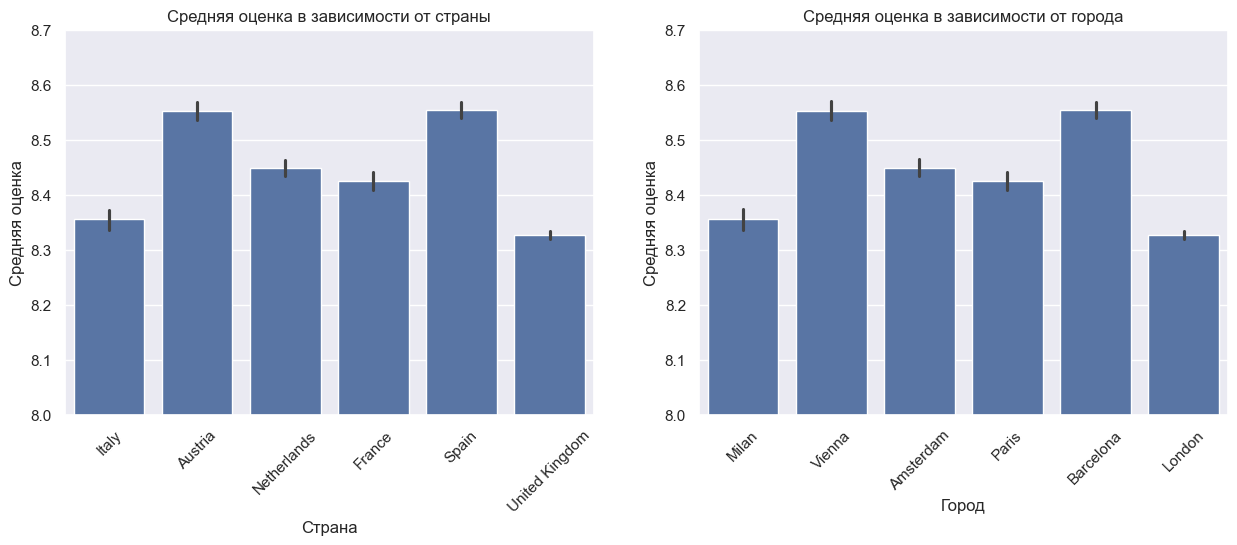

In [217]:
# Визуализация данных
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot( hotels[hotels['sample']==1], x='hotel_country', y='reviewer_score',
            order=['Italy', 'Austria' ,'Netherlands', 'France', 'Spain', 'United Kingdom' ],
            ax=axes[0]
            )
axes[0].set(xlabel='Страна', ylabel='Средняя оценка')
axes[0].xaxis.set_tick_params(rotation = 45)
axes[0].set_title('Средняя оценка в зависимости от страны')
axes[0].set_ylim(8, 8.7)

sns.barplot(hotels[hotels['sample']==1], x='hotel_city', y='reviewer_score',
            order=['Milan', 'Vienna' , 'Amsterdam' , 'Paris', 'Barcelona', 'London'],
            ax=axes[1]
            )
axes[1].set(xlabel='Город', ylabel='Средняя оценка')
axes[1].xaxis.set_tick_params(rotation = 45)
axes[1].set_title('Средняя оценка в зависимости от города')
axes[1].set_ylim(8, 8.7)

На графиках видна корреляция между страной и городом (что абсолютно естественно, потому что получены эти признаки из одного родительского). Вдальнейшем удалим признак "Город", но пока рн нам понадобиться при работе с признаками lat и lng.

In [218]:
# кодируем страну отеля
hotels['hotel_country'] = hotels['hotel_country'].astype('category')
hotels['hotel_country_code'] = hotels['hotel_country'].cat.codes

# кодируем город отеля
hotels['hotel_city'] = hotels['hotel_city'].astype('category')
hotels['hotel_city_code'] = hotels['hotel_city'].cat.codes

# проверяем результат
hotels[['hotel_country', 'hotel_country_code', 'hotel_city', 'hotel_city_code']]

,hotel_country,hotel_country_code,hotel_city,hotel_city_code
0,Italy,2,Milan,3
1,Netherlands,3,Amsterdam,0
2,Spain,4,Barcelona,1
3,Italy,2,Milan,3
4,Netherlands,3,Amsterdam,0
...,...,...,...,...
515426,United Kingdom,5,London,2
515427,Austria,0,Vienna,5
515428,United Kingdom,5,London,2
515429,United Kingdom,5,London,2


# 2.2. Преобразование признаков 'lat, lng' - заполнение пропусков в данных

Благодоря полученным ранее двум новым признакам - страна и город отеля, можно с определенной точностью заполнить пропуски в 'lat', 'lng'. Заполним их медианными значениями lat, lng по городам, в которых находятся эти отели.

In [219]:
# посмотрим, как пропуски в 'lat' распределяются по городам
print(hotels[hotels['lat'].isnull()].groupby('hotel_city', as_index=False).agg(qty=('hotel_city', 'count')),'\n')

print()
# посмотрим, как пропуски в 'lng' распределяются по городам (идентично 'lat')
print(hotels[hotels['lng'].isnull()].groupby('hotel_city', as_index=False).agg(qty=('hotel_city', 'count')))

  hotel_city   qty
0  Amsterdam     0
1  Barcelona   207
2     London     0
3      Milan     0
4      Paris   382
5     Vienna  2679 


  hotel_city   qty
0  Amsterdam     0
1  Barcelona   207
2     London     0
3      Milan     0
4      Paris   382
5     Vienna  2679


C:\Users\Professional\AppData\Local\Temp\ipykernel_12692\2062552163.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(hotels[hotels['lat'].isnull()].groupby('hotel_city', as_index=False).agg(qty=('hotel_city', 'count')),'\n')
C:\Users\Professional\AppData\Local\Temp\ipykernel_12692\2062552163.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(hotels[hotels['lng'].isnull()].groupby('hotel_city', as_index=False).agg(qty=('hotel_city', 'count')))


In [220]:
# делаем копию датафрейма для исключения конфликта манипуляций с данными
hotels_coords = hotels.copy()

# формируем объект SeriesGroupBy
city = hotels_coords.groupby(['hotel_city'], group_keys=False)

# найдем медианные координаты с учетом образовавшихся групп
city['lat'].median()
city['lng'].median()

# Применим lambda-функцию к SeriesGroupBy, заменяем пропуски соответствующим медианным значением
hotels_coords['lat'] = city['lat'].apply(lambda x: x.fillna(x.median()))
hotels_coords['lng'] = city['lng'].apply(lambda x: x.fillna(x.median()))

C:\Users\Professional\AppData\Local\Temp\ipykernel_12692\42878835.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  city = hotels_coords.groupby(['hotel_city'], group_keys=False)


In [221]:
# переносим результат в исходный датафрейм
hotels = hotels_coords

# сверяемся с типом признаков
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 22 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   hotel_address                               515431 non-null  object  
 1   additional_number_of_scoring                515431 non-null  int64   
 2   review_date                                 515431 non-null  object  
 3   average_score                               515431 non-null  float64 
 4   hotel_name                                  515431 non-null  object  
 5   reviewer_nationality                        515431 non-null  object  
 6   negative_review                             515431 non-null  object  
 7   review_total_negative_word_counts           515431 non-null  int64   
 8   total_number_of_reviews                     515431 non-null  int64   
 9   positive_review                             515431 non-null

In [222]:
# ищем в столбцах данные, содержащие пропущенные значения
hotels.isnull().sum()

hotel_address                                 0
additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
sample                                        0
reviewer_score                                0
hotel_country                                 0
hotel_city                                    0
hotel_country_code                      

Пропуски отсудствуют, теперь можно удалить признак "Город"

In [223]:
hotels = hotels.drop(['hotel_city'], axis = 1)
hotels = hotels.drop(['hotel_city_code'], axis = 1)

# 2.3. Преобразование признака 'tags'

In [224]:
hotels['tags'].head()

0    [' Leisure trip ', ' Couple ', ' Double Room '...
1    [' Leisure trip ', ' Group ', ' Triple Room ',...
2    [' Business trip ', ' Solo traveler ', ' Twin ...
3    [' Leisure trip ', ' Couple ', ' Ambassador Ju...
4    [' Business trip ', ' Solo traveler ', ' Class...
Name: tags, dtype: object

Довольно содержательный и в то же время  "загрязненный" по структуре признак, с его помощью можно создать несколько дополнительных признаков 

In [225]:
# очистим строку oт лишних символов

def tagsclean(tags):
    tags = tags.replace('[', '')
    tags = tags.replace(']', '')
    tags = tags.replace("'", '')
    
    return tags.split(',')
    
hotels['tags_new'] = hotels['tags'].apply(tagsclean)
hotels

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,hotel_country,hotel_country_code,tags_new
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,...,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0,Italy,2,"[ Leisure trip , Couple , Double Room , ..."
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,...,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0,Netherlands,3,"[ Leisure trip , Group , Triple Room , S..."
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,...,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0,Spain,4,"[ Business trip , Solo traveler , Twin Roo..."
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,...,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298,0,0.0,Italy,2,"[ Leisure trip , Couple , Ambassador Junio..."
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,...,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644,0,0.0,Netherlands,3,"[ Business trip , Solo traveler , Classic ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515426,9 Knaresborough Place Kensington and Chelsea L...,107,4/19/2017,9.0,Hotel Moonlight,France,No Negative,0,617,Tr s proche du metro Earl s court,...,10,"[' Leisure trip ', ' Group ', ' Club Double or...",106 day,51.494028,-0.191050,1,8.8,United Kingdom,5,"[ Leisure trip , Group , Club Double or Tw..."
515427,Landstra er Hauptstra e 155 03 Landstra e 1030...,272,2/13/2017,8.4,BEST WESTERN PLUS Amedia Wien,Turkey,No Negative,0,3224,The bed was so comfy I stayed with my boyfrie...,...,1,"[' Leisure trip ', ' Couple ', ' Standard Doub...",171 day,48.192379,16.399451,1,9.2,Austria,0,"[ Leisure trip , Couple , Standard Double ..."
515428,29 31 Gower Street Camden London WC1E 6HG Unit...,457,2/7/2016,6.8,Bloomsbury Palace Hotel,Netherlands,room is really small but guess is normal in L...,12,2751,great location simple check in out nice shower,...,21,"[' Business trip ', ' Solo traveler ', ' Singl...",543 day,51.520795,-0.131084,1,8.3,United Kingdom,5,"[ Business trip , Solo traveler , Single R..."
515429,31 Great Cumberland Place Westminster Borough ...,365,5/21/2017,8.1,The Marble Arch London,United Arab Emirates,No Negative,0,1567,Location and very comfy bed,...,28,"[' Leisure trip ', ' Solo traveler ', ' Deluxe...",74 days,51.515125,-0.160066,1,9.2,United Kingdom,5,"[ Leisure trip , Solo traveler , Deluxe Do..."


In [226]:
dict_tags = {}

for list_tag in hotels['tags']:
    list_tags = ast.literal_eval(list_tag)
    
    if type(list_tags) is list:
       for tag in list_tags:
           if tag.strip() in dict_tags:
              dict_tags[tag.strip()] += 1
           else:
              dict_tags[tag.strip()] = 1
sorted_tuple = sorted(dict_tags.items(), key=lambda x: x[1],reverse=True)
dict_tags_sort =  dict(sorted_tuple)
print('Количество уникальных тегов:',len(dict_tags_sort))
print('Словарь тегов:',dict_tags_sort)

Количество уникальных тегов: 2428
Словарь тегов: {'Leisure trip': 417538, 'Submitted from a mobile device': 307470, 'Couple': 252128, 'Stayed 1 night': 193568, 'Stayed 2 nights': 133850, 'Solo traveler': 108476, 'Stayed 3 nights': 95761, 'Business trip': 82884, 'Group': 65361, 'Family with young children': 60989, 'Stayed 4 nights': 47777, 'Double Room': 35207, 'Standard Double Room': 32247, 'Superior Double Room': 31361, 'Family with older children': 26334, 'Deluxe Double Room': 24812, 'Double or Twin Room': 22393, 'Stayed 5 nights': 20826, 'Standard Double or Twin Room': 17479, 'Classic Double Room': 16877, 'Superior Double or Twin Room': 13570, '2 rooms': 12384, 'Stayed 6 nights': 9765, 'Standard Twin Room': 9745, 'Single Room': 9668, 'Twin Room': 8320, 'Stayed 7 nights': 7391, 'Executive Double Room': 6425, 'Classic Double or Twin Room': 6100, 'Superior Twin Room': 6054, 'Deluxe Double or Twin Room': 5996, 'Club Double Room': 5908, 'Queen Room': 5472, 'Deluxe King Room': 5357, 'Supe

Вид поездки

In [227]:
# Выделим тип поездки из поля тэгов 

def trip(tags):
    
    for curr_tag in tags:
        
        if 'trip' in curr_tag.strip():
            return curr_tag.strip()
        
    return 'Not a trip'

hotels['trip'] = hotels['tags_new'].apply(trip)
hotels.head(5)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,tags,days_since_review,lat,lng,sample,reviewer_score,hotel_country,hotel_country_code,tags_new,trip
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,...,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0,Italy,2,"[ Leisure trip , Couple , Double Room , ...",Leisure trip
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,...,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0,Netherlands,3,"[ Leisure trip , Group , Triple Room , S...",Leisure trip
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,...,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0,Spain,4,"[ Business trip , Solo traveler , Twin Roo...",Business trip
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,...,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298,0,0.0,Italy,2,"[ Leisure trip , Couple , Ambassador Junio...",Leisure trip
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,...,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644,0,0.0,Netherlands,3,"[ Business trip , Solo traveler , Classic ...",Business trip


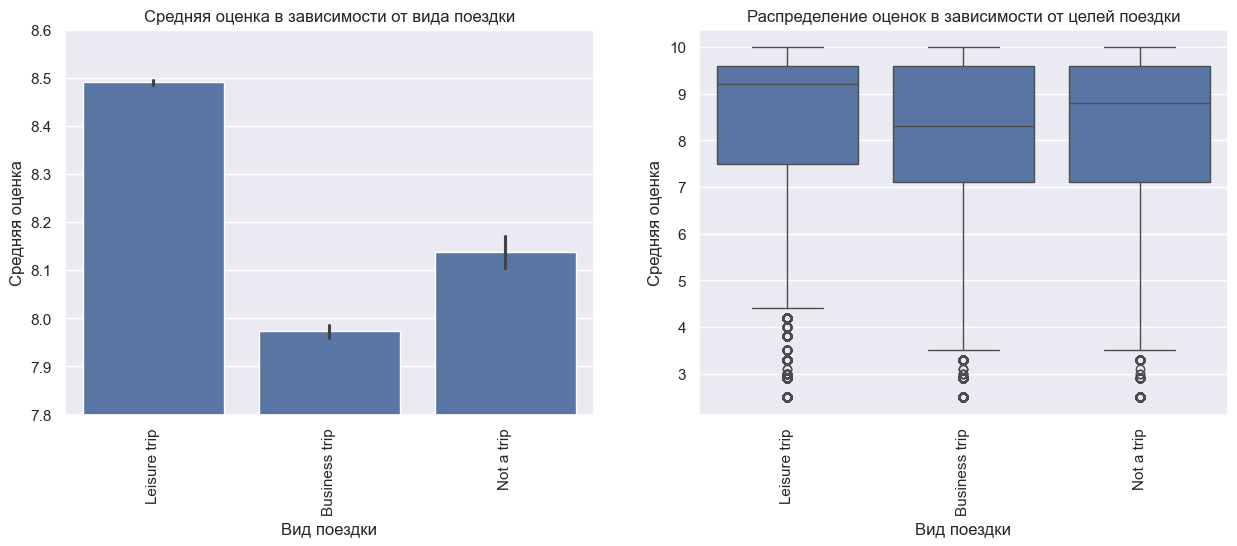

In [228]:
# Визуализация данных
fig, axes = plt.subplots(1, 2,  figsize=(15, 5))
plt.subplots_adjust(hspace=0.6)

sns.barplot(hotels[hotels['sample']==1], x='trip' , y= 'reviewer_score', ax=axes[0])
axes[0].set(xlabel='Вид поездки', ylabel='Средняя оценка')
axes[0].xaxis.set_tick_params(rotation = 90)
axes[0].set_title('Средняя оценка в зависимости от вида поездки')
axes[0].set_ylim(7.8, 8.6)

sns.boxplot(hotels[hotels['sample']==1], x='trip' , y= 'reviewer_score', ax=axes[1])
axes[1].set(xlabel='Вид поездки', ylabel='Средняя оценка')
axes[1].set_title('Распределение оценок в зависимости от целей поездки')
axes[1].xaxis.set_tick_params(rotation = 90)
plt.show()

По полученым графикам можно сделать вывод о влиянии вида поездки на оценку.

In [229]:
# Кодируем признак вид поездки
encoder = ce.OneHotEncoder(cols = ['trip'], use_cat_names = True)
type_bin = encoder.fit_transform(hotels['trip'])
hotels = pd.concat([hotels, type_bin], axis = 1)

Способ отправки отзыва

In [230]:
def mobile(tags):
    
    for curr_tag in tags:
        if 'mobile' in curr_tag:
            return 1
    return 0
hotels['mobile_dev'] = hotels['tags_new'].apply(mobile)
hotels.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,sample,reviewer_score,hotel_country,hotel_country_code,tags_new,trip,trip_Leisure trip,trip_Business trip,trip_Not a trip,mobile_dev
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,...,0,0.0,Italy,2,"[ Leisure trip , Couple , Double Room , ...",Leisure trip,1,0,0,0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,...,0,0.0,Netherlands,3,"[ Leisure trip , Group , Triple Room , S...",Leisure trip,1,0,0,0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,...,0,0.0,Spain,4,"[ Business trip , Solo traveler , Twin Roo...",Business trip,0,1,0,1
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,...,0,0.0,Italy,2,"[ Leisure trip , Couple , Ambassador Junio...",Leisure trip,1,0,0,0
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,...,0,0.0,Netherlands,3,"[ Business trip , Solo traveler , Classic ...",Business trip,0,1,0,1


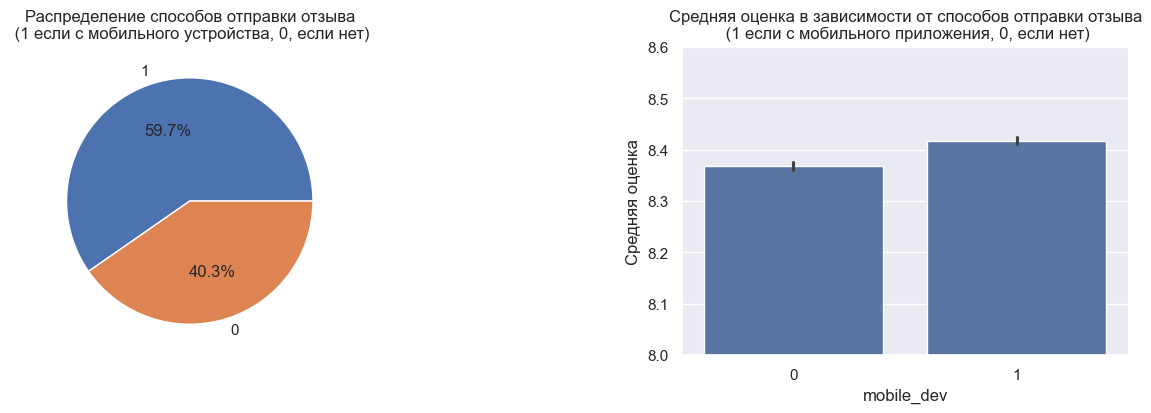

In [231]:
# Визуализация данных
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
plt.subplots_adjust(wspace=0.6)


axes[0].pie(hotels[hotels['sample']==1]['mobile_dev'].value_counts(), 
            labels = hotels[hotels['sample']==1]['mobile_dev'].value_counts().index, 
            autopct = '%.1f%%')
axes[0].set_title('Распределение способов отправки отзыва\n (1 если с мобильного устройства, 0, если нет)')

# Строим столбчатую диаграмму для визуализации средней оценки в зависимости от способов отправки отзыва
sns.barplot(hotels[hotels['sample']==1],x ='mobile_dev', y = 'reviewer_score',
            ax=axes[1])
axes[1].set(ylabel='Средняя оценка')
axes[1].set_title('Средняя оценка в зависимости от способов отправки отзыва\n (1 если с мобильного приложения, 0, если нет)')

plt.ylim(8, 8.6)
plt.show()

Большинство отзывов отправлены с мобильных устройств, однако на оценку это не оказывает заметного влияния.

Статус гостя

In [232]:
def guest_status(tags):
    status = ['Couple', 'Solo traveler', 'Group', 'Family with young children', 'Family with older children', 'Travelers with friends', 'With a pet']
    
    for curr_stat in status:
        if curr_stat in tags:
            return curr_stat
        
    return None

hotels['guest_stat'] = hotels['tags'].apply(guest_status)

In [233]:
hotels['guest_stat'].value_counts()

guest_stat
Couple                        252128
Solo traveler                 108476
Group                          65361
Family with young children     60989
Family with older children     26334
Travelers with friends          2143
Name: count, dtype: int64

In [234]:
hotels['guest_stat'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 515431 entries, 0 to 515430
Series name: guest_stat
Non-Null Count   Dtype 
--------------   ----- 
515431 non-null  object
dtypes: object(1)
memory usage: 3.9+ MB


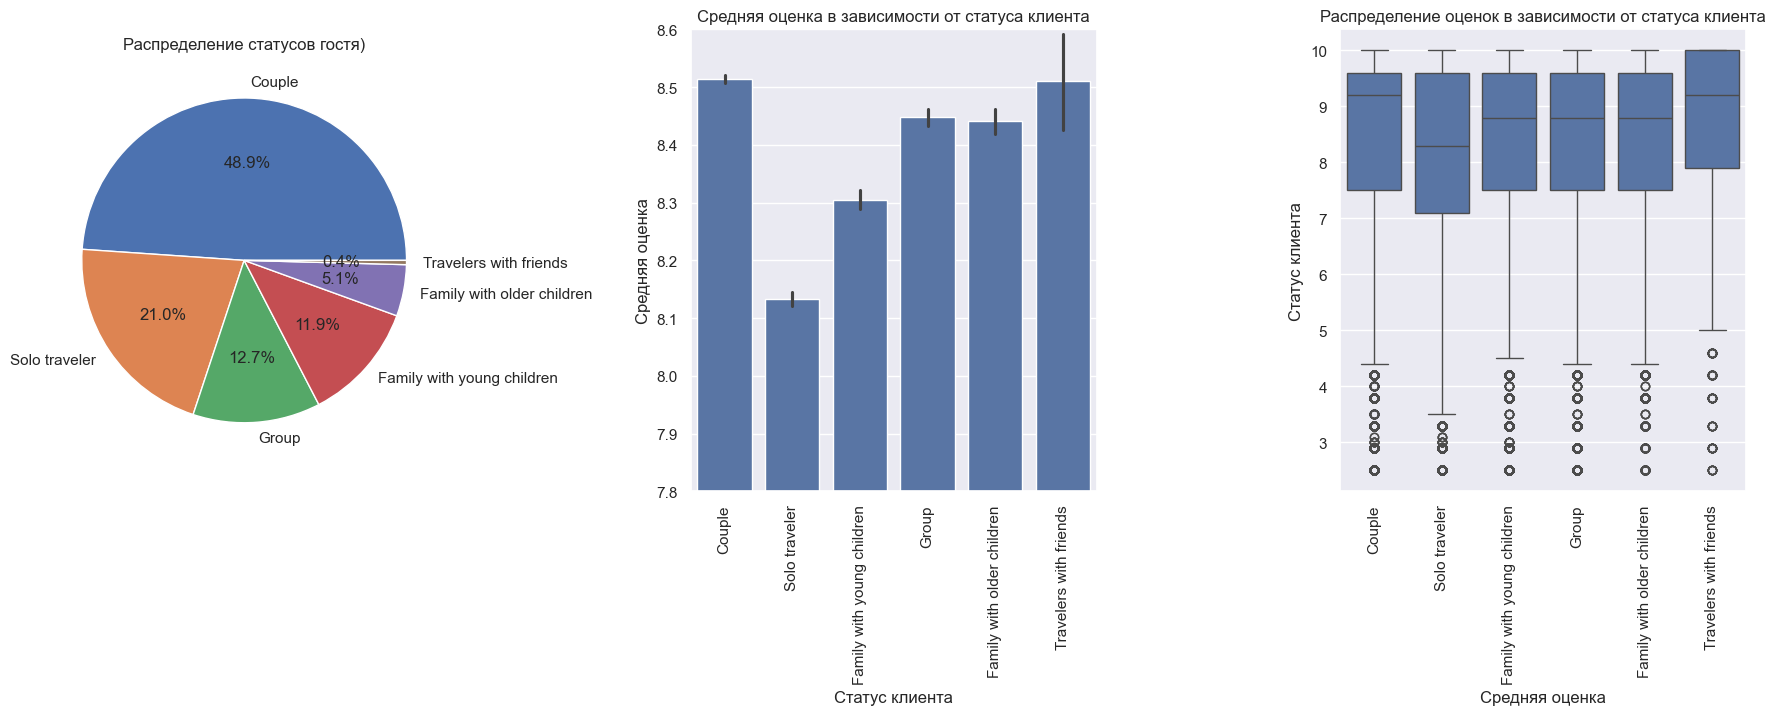

In [235]:
# Визуализация данных
fig, axes = plt.subplots(1, 3, figsize=(22, 6))
plt.subplots_adjust(wspace=0.6)

axes[0].pie(hotels[hotels['sample']==1]['guest_stat'].value_counts(), 
            labels = hotels[hotels['sample']==1]['guest_stat'].value_counts().index, 
            autopct = '%.1f%%')
axes[0].set_title('Распределение статусов гостя)')

# Строим столбчатую диаграмму для визуализации средней оценки в зависимости от статуса клиента
sns.barplot(hotels[hotels['sample']==1],x='guest_stat',y='reviewer_score',
            ax=axes[1])

axes[1].set(xlabel='Статус клиента', ylabel='Средняя оценка')
axes[1].xaxis.set_tick_params(rotation = 90)
axes[1].set_title('Средняя оценка в зависимости от статуса клиента')
axes[1].set_ylim(7.8, 8.6)

# Строим коробчатую диаграмму для визуализации распределения оценок в зависимости от статуса клиента
sns.boxplot(hotels[hotels['sample']==1], x='guest_stat',y='reviewer_score',
            ax=axes[2]
            )
axes[2].set(xlabel='Средняя оценка', ylabel='Статус клиента')
axes[2].set_title('Распределение оценок в зависимости от статуса клиента')
axes[2].xaxis.set_tick_params(rotation = 90)
plt.show()

На графиках видна зависимость оценки от данного признака, при этом почти половина гостей путешествуют парами.

In [236]:
# Кодируем признак статуса гостя
encoder = ce.OneHotEncoder(cols = ['guest_stat'], use_cat_names = True)
type_bin = encoder.fit_transform(hotels['guest_stat'])
hotels = pd.concat([hotels, type_bin], axis = 1)

Количество ночей проживания

In [237]:
def night_quant(tags):
    
    for tag in tags:
        if 'Stayed' in tag:
            return str(tag)
            
    return 'Stayed, 0, night'

hotels['night_quantity'] = hotels['tags_new'].apply(night_quant)

In [238]:
hotels['night_quantity'].value_counts(normalize=True)

night_quantity
  Stayed 1 night       0.375546
  Stayed 2 nights      0.259686
  Stayed 3 nights      0.185788
  Stayed 4 nights      0.092693
  Stayed 5 nights      0.040405
  Stayed 6 nights      0.018945
  Stayed 7 nights      0.014339
  Stayed 8 nights      0.004848
  Stayed 9 nights      0.002509
  Stayed 10 nights     0.001723
  Stayed 11 nights     0.000809
  Stayed 12 nights     0.000613
  Stayed 14 nights     0.000479
  Stayed 13 nights     0.000477
Stayed, 0, night       0.000373
  Stayed 15 nights     0.000227
  Stayed 16 nights     0.000111
  Stayed 17 nights     0.000081
  Stayed 18 nights     0.000064
  Stayed 19 nights     0.000056
  Stayed 21 nights     0.000045
  Stayed 20 nights     0.000037
  Stayed 27 nights     0.000021
  Stayed 30 nights     0.000021
  Stayed 23 nights     0.000019
  Stayed 22 nights     0.000019
  Stayed 25 nights     0.000014
  Stayed 26 nights     0.000014
  Stayed 28 nights     0.000014
  Stayed 24 nights     0.000012
  Stayed 29 nights     0.

In [239]:
hotels['night_quantity'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 515431 entries, 0 to 515430
Series name: night_quantity
Non-Null Count   Dtype 
--------------   ----- 
515431 non-null  object
dtypes: object(1)
memory usage: 3.9+ MB


Количество уникальных значений достаточно велико, оставим 15 самых частовстречающихся.

In [240]:
count_night_quantity = (hotels['night_quantity'].value_counts(normalize = True))
night_quantity_sorted = count_night_quantity.sort_values(ascending = False)
night_quantity_pop = night_quantity_sorted.nlargest(15).index
hotels['night_quantity'] = hotels['night_quantity'].apply(lambda x: x if x in night_quantity_pop else 'Other')
hotels['night_quantity'].value_counts()

night_quantity
  Stayed 1 night       193568
  Stayed 2 nights      133850
  Stayed 3 nights       95761
  Stayed 4 nights       47777
  Stayed 5 nights       20826
  Stayed 6 nights        9765
  Stayed 7 nights        7391
  Stayed 8 nights        2499
  Stayed 9 nights        1293
  Stayed 10 nights        888
  Stayed 11 nights        417
Other                     395
  Stayed 12 nights        316
  Stayed 14 nights        247
  Stayed 13 nights        246
Stayed, 0, night          192
Name: count, dtype: int64

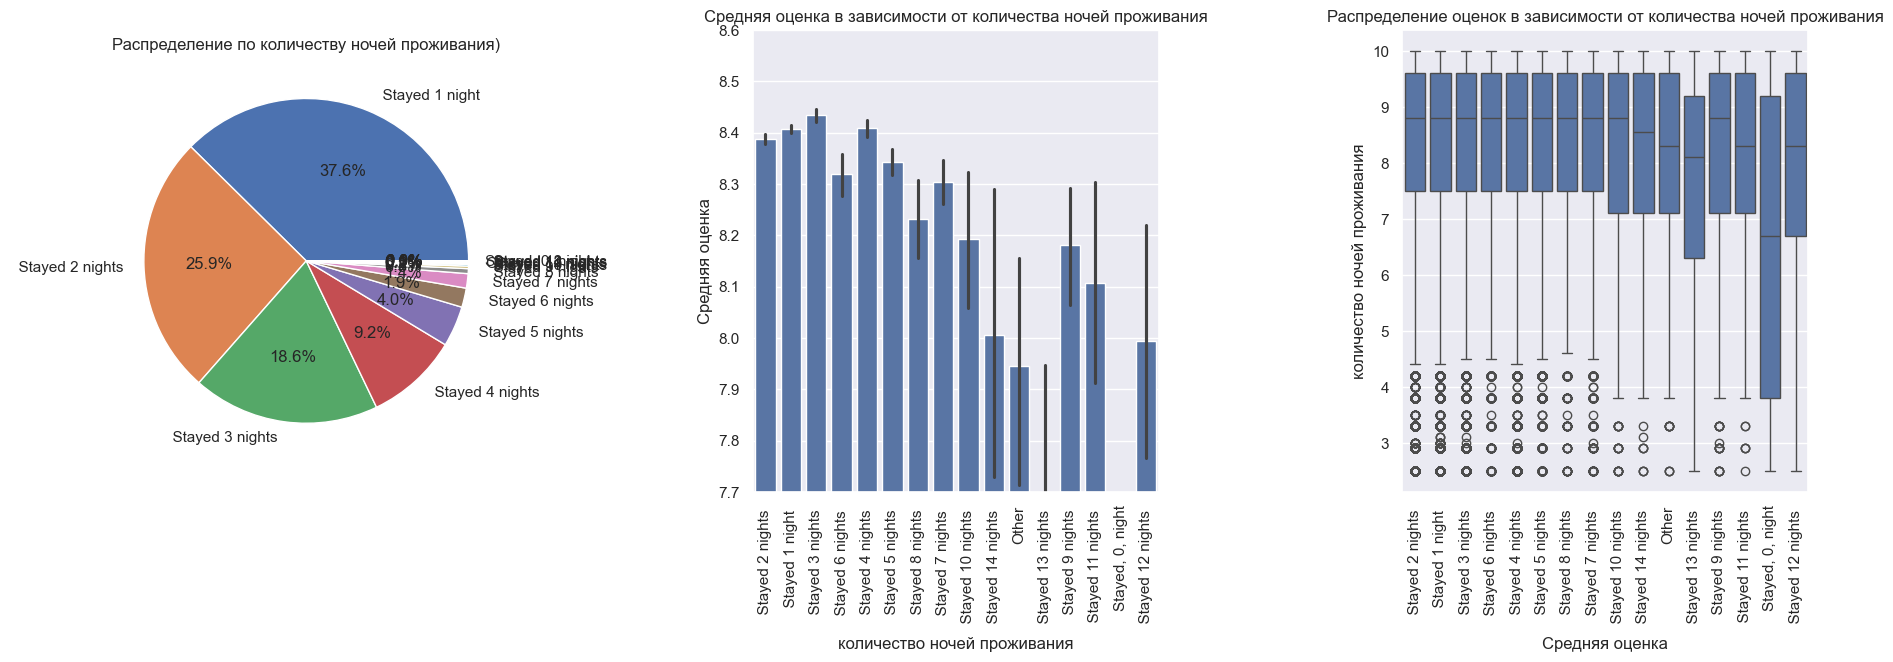

In [241]:
# Визуализация данных
fig, axes = plt.subplots(1, 3, figsize=(22, 6))
plt.subplots_adjust(wspace=0.6)

axes[0].pie(hotels[hotels['sample']==1]['night_quantity'].value_counts(), 
            labels = hotels[hotels['sample']==1]['night_quantity'].value_counts().index, 
            autopct = '%.1f%%'
            )
axes[0].set_title('Распределение по количеству ночей проживания)')

# Строим столбчатую диаграмму для визуализации средней оценки в зависимости от количества ночей проживания
sns.barplot(hotels[hotels['sample']==1],x='night_quantity',y='reviewer_score',
            ax=axes[1]
            )
axes[1].set(xlabel='количество ночей проживания', ylabel='Средняя оценка')
axes[1].xaxis.set_tick_params(rotation = 90)
axes[1].set_title('Средняя оценка в зависимости от количества ночей проживания')
axes[1].set_ylim(7.7, 8.6)

# Строим коробчатую диаграмму для визуализации распределения оценок в зависимости от количества ночей проживания
sns.boxplot(hotels[hotels['sample']==1], x='night_quantity',y='reviewer_score',
            ax=axes[2]
            )
axes[2].set(xlabel='Средняя оценка', ylabel='количество ночей проживания')
axes[2].set_title('Распределение оценок в зависимости от количества ночей проживания')
axes[2].xaxis.set_tick_params(rotation = 90)
plt.show()

На основе представленных графиков, можно сделать вывод о том, чаше всего останавливаються на 1 ночь, при этом связь между этим признаком и оценкой отеля присутствует.

In [242]:
# Кодируем признак количество ночей
encoder = ce.OneHotEncoder(cols = ['night_quantity'], use_cat_names = True)
type_bin = encoder.fit_transform(hotels['night_quantity'])
hotels = pd.concat([hotels, type_bin], axis = 1)

Условия проживания (количество и вид комнат в номере)

In [243]:
def room_def(tags):
    
    for room in tags:
        if 'Room' in room:
            return room
        if 'Suite' in room:
            return room
    return 'Unknown'

hotels['rooms'] = hotels['tags_new'].apply(room_def)
hotels['rooms'].value_counts(normalize=True)

rooms
  Double Room                            0.068306
  Standard Double Room                   0.062563
  Superior Double Room                   0.060844
Unknown                                  0.059950
  Deluxe Double Room                     0.048138
                                           ...   
  Superior Junior Suite Single Use       0.000002
  Superior Suite Water Front             0.000002
  Suite Aurore                           0.000002
  Executive Suite 1 King                 0.000002
  Quadruple Room 2 Adults 2 Children     0.000002
Name: proportion, Length: 2143, dtype: float64

Видим более 2000 вариантов, оставим 30 самых часто встречающихся.

In [244]:
count_room = (hotels['rooms'].value_counts(normalize = True))
room_sorted = count_room.sort_values(ascending = False)
room_pop = room_sorted.nlargest(30).index
hotels['rooms'] = hotels['rooms'].apply(lambda x: x if x in room_pop else 'Other')
hotels['rooms'].value_counts(normalize=True)

rooms
Other                              0.339093
  Double Room                      0.068306
  Standard Double Room             0.062563
  Superior Double Room             0.060844
Unknown                            0.059950
  Deluxe Double Room               0.048138
  Double or Twin Room              0.043445
  Standard Double or Twin Room     0.033911
  Classic Double Room              0.032743
  Superior Double or Twin Room     0.026327
  Standard Twin Room               0.018907
  Single Room                      0.018757
  Twin Room                        0.016142
  Executive Double Room            0.012465
  Classic Double or Twin Room      0.011835
  Superior Twin Room               0.011746
  Deluxe Double or Twin Room       0.011633
  Club Double Room                 0.011462
  Queen Room                       0.010616
  Deluxe King Room                 0.010393
  Superior Queen Room              0.009501
  Standard Single Room             0.008954
  Junior Suite            

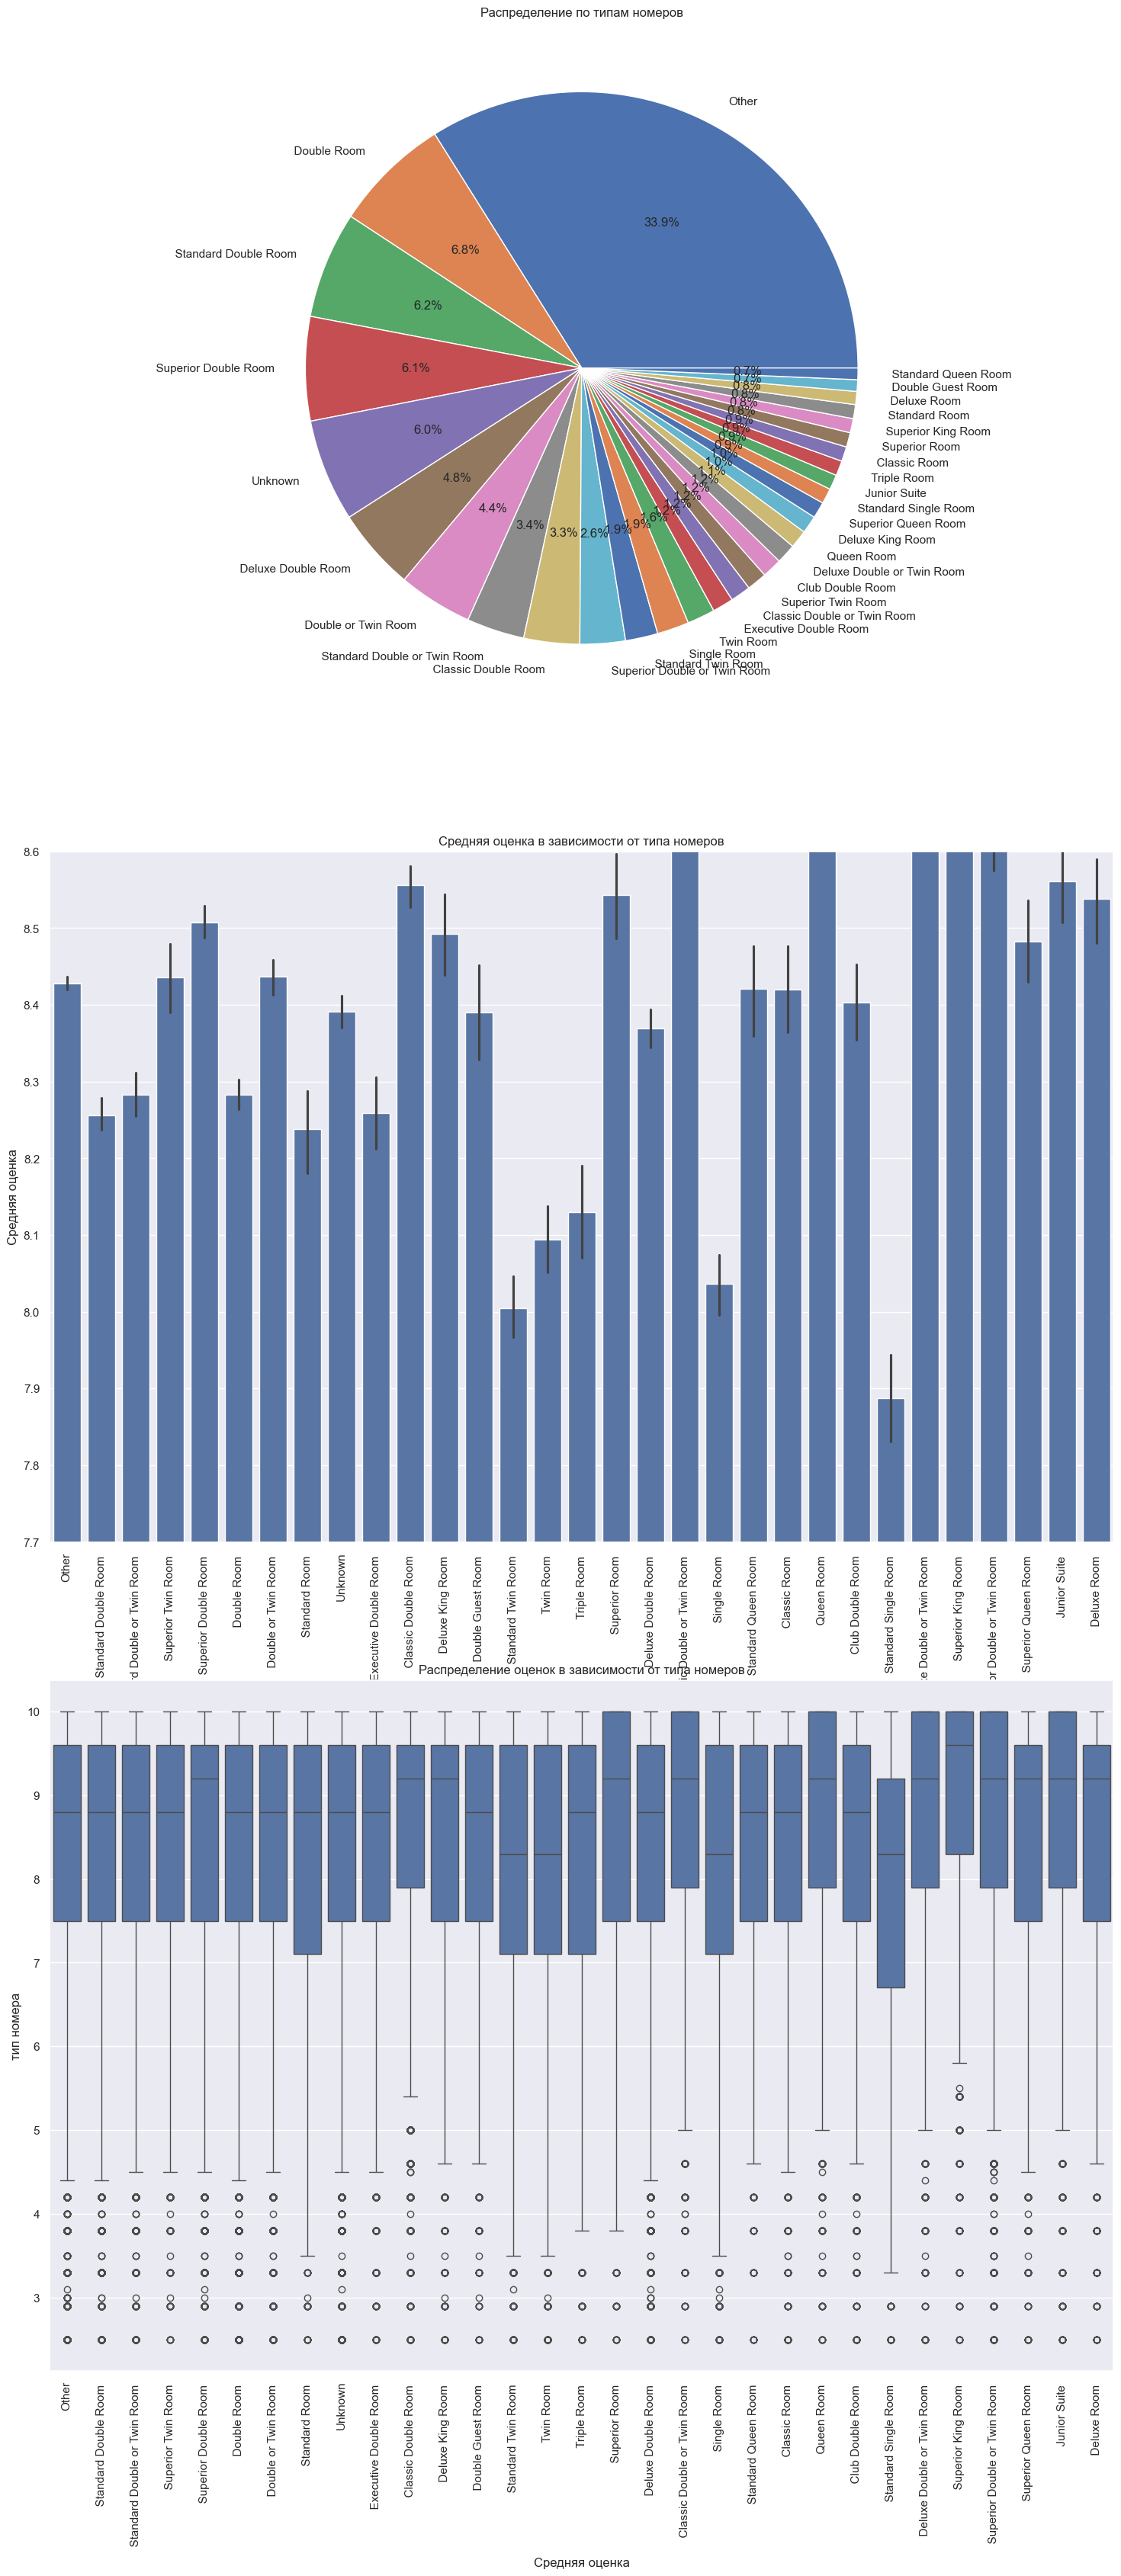

In [245]:
# Визуализация данных
ig, axes = plt.subplots(3, 1, figsize=(18, 40))
plt.subplots_adjust(wspace=0.6)

axes[0].pie(hotels[hotels['sample']==1]['rooms'].value_counts(), 
            labels = hotels[hotels['sample']==1]['rooms'].value_counts().index, 
            autopct = '%.1f%%')
axes[0].set_title('Распределение по типам номеров')

# Строим столбчатую диаграмму для визуализации средней оценки в зависимости от типа номеров
sns.barplot(hotels[hotels['sample']==1],x='rooms',y='reviewer_score',
            ax=axes[1])

axes[1].set(xlabel='тип номера', ylabel='Средняя оценка')
axes[1].xaxis.set_tick_params(rotation = 90)
axes[1].set_title('Средняя оценка в зависимости от типа номеров')
axes[1].set_ylim(7.7, 8.6)

# Строим коробчатую диаграмму для визуализации распределения оценок в зависимости от типа номеров
sns.boxplot(hotels[hotels['sample']==1], x='rooms',y='reviewer_score',
            ax=axes[2])

axes[2].set(xlabel='Средняя оценка', ylabel='тип номера')
axes[2].set_title('Распределение оценок в зависимости от типа номеров')
axes[2].xaxis.set_tick_params(rotation = 90)
plt.show()

На представленных графиках видна зависимость оценки от типа номера

In [246]:
# Кодируем признак вида комнаты
bin_encoder = ce.BinaryEncoder(cols = ['rooms'])
type_bin = bin_encoder.fit_transform(hotels['rooms'])
hotels = pd.concat([hotels, type_bin], axis = 1)

In [247]:
# сверяемся с типом признаков
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 56 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   hotel_address                               515431 non-null  object  
 1   additional_number_of_scoring                515431 non-null  int64   
 2   review_date                                 515431 non-null  object  
 3   average_score                               515431 non-null  float64 
 4   hotel_name                                  515431 non-null  object  
 5   reviewer_nationality                        515431 non-null  object  
 6   negative_review                             515431 non-null  object  
 7   review_total_negative_word_counts           515431 non-null  int64   
 8   total_number_of_reviews                     515431 non-null  int64   
 9   positive_review                             515431 non-null

# 2.4 Преобразование признака 'review_date'

In [248]:
# 'review_date' переводим в формат datetime64
hotels['review_date'] = pd.to_datetime(hotels['review_date'], yearfirst=True)

Text(0.5, 1.0, 'Распределение получения данных по месяцам')

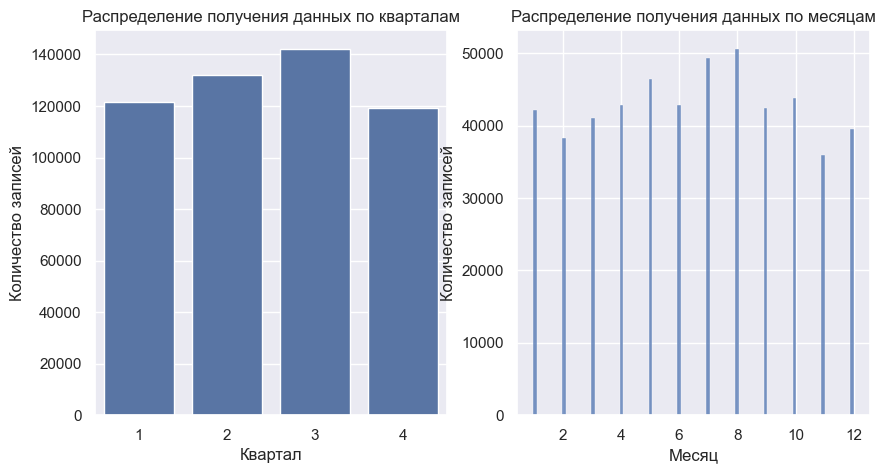

In [249]:
# проверим сеззоность оценок
hotels['review_month'] = pd.to_datetime(hotels['review_date']).dt.month
hotels['review_quarter'] = pd.to_datetime(hotels['review_date']).dt.quarter

sns.set (font_scale= 1 )
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0] = sns.countplot(hotels, x='review_quarter', ax=axes[0])
axes[0].set(xlabel='Квартал', ylabel='Количество записей')
axes[0].set_title('Распределение получения данных по кварталам')

axes[1] = sns.histplot(hotels['review_month'], ax=axes[1])
axes[1].set(xlabel='Месяц', ylabel='Количество записей')
axes[1].set_title('Распределение получения данных по месяцам')

Из-за связи между оценкой рецензента и сезонностью применим кодирование Target Encoding, таким кодированием сформируем "веса" признака 'review_date' в зависимости от оценки рецензента. Параметры кодировщика использованы стандартные, по умолчанию.

In [250]:
# создаём новый признак 'год-месяц'
hotels['year_month'] = hotels['review_date'].dt.to_period("M")

# кодируем признак 'year_month'
hotels['year_month'] = hotels['year_month'].astype('category')
period_te = ce.TargetEncoder(min_samples_leaf=20, smoothing=10).fit_transform(hotels['year_month'], hotels['reviewer_score'])

# переименовываем признак для удобства "отсева"
period_te.rename(columns={'year_month': 'year_month_te'}, inplace=True)
hotels = pd.concat([hotels, period_te], axis=1)

# удаляем признаки дублирующие информацию
hotels.drop(['review_month'], axis = 1, inplace=True)
hotels.drop(['review_quarter'], axis = 1, inplace=True)

# смотрим результат
hotels[['year_month', 'year_month_te']]

c:\Users\Professional\AppData\Local\Programs\Python\Python39\lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
c:\Users\Professional\AppData\Local\Programs\Python\Python39\lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
c:\Users\Professional\AppData\Local\Programs\Python\Python39\lib\site-packages\category_encoders\ord

,year_month,year_month_te
0,2017-07,6.226917
1,2016-12,6.309935
2,2015-11,6.248972
3,2015-10,6.192165
4,2016-05,6.303538
...,...,...
515426,2017-04,6.294064
515427,2017-02,6.384816
515428,2016-02,6.397145
515429,2017-05,6.208258


# 2.5 Преобразование признака 'hotel_name'

In [251]:
# собираем сводную таблицу с уникальным числом имён отелей и адресами
pivot_name_addr = hotels[['hotel_address', 'hotel_name']].groupby(by='hotel_name').nunique()

# отсеиваем отели с именами-дубликатами
mask_hotel_name = pivot_name_addr['hotel_address'] != 1
hotel_name_dupl = pivot_name_addr[mask_hotel_name].index.to_list()

# выводим число отелей с именами-дубликатами
mask_name_dupl = hotels['hotel_name'].isin(hotel_name_dupl)
hotel_addr_dupl = hotels[mask_name_dupl][['hotel_name', 'hotel_address']].value_counts()
hotel_addr_dupl

hotel_name    hotel_address                                             
Hotel Regina  Bergara 2 4 Eixample 08002 Barcelona Spain                    590
              Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria           284
              Via Cesare Correnti 13 Milan City Center 20123 Milan Italy     60
Name: count, dtype: int64

In [252]:
# модифицируем названия отелей, добавив в название город
hotels['hotel_name'] = hotels.apply(lambda row: (row['hotel_name'] + ' ' + row['hotel_address'].split()[-2])
                                    if (row['hotel_name'] in hotel_name_dupl)
                                    else row['hotel_name'], axis=1)

# смотрим результат
mask = hotels['hotel_name'].str.contains(hotel_name_dupl[0])
hotels[mask]['hotel_name'].value_counts()

hotel_name
Hotel Regina Barcelona    590
Hotel Regina Vienna       284
Hotel Regina Milan         60
Name: count, dtype: int64

In [253]:
# кодируем hotel_name - данный признак в первую очередь служить для групировки отзывав, из за этого его не удоляем
hotels['hotel_name'] = hotels['hotel_name'].astype('category')
hotels['hotel_name_code'] = hotels['hotel_name'].cat.codes

# смотрим результат
hotels['hotel_name_code']

0          612
1         1447
2           33
3          735
4          633
          ... 
515426     711
515427     104
515428     177
515429    1366
515430    1373
Name: hotel_name_code, Length: 515431, dtype: int16

# 2.6 Преобразование признака 'reviewer_nationality'

In [254]:
hotels['reviewer_nationality'].describe()

count               515431
unique                 227
top        United Kingdom 
freq                245165
Name: reviewer_nationality, dtype: object

In [255]:
hotels['reviewer_nationality'].value_counts()

reviewer_nationality
United Kingdom               245165
United States of America      35390
Australia                     21663
Ireland                       14820
United Arab Emirates          10230
                              ...  
Comoros                           1
Anguilla                          1
Tuvalu                            1
Cape Verde                        1
Palau                             1
Name: count, Length: 227, dtype: int64

В данных присутствует 227 национальностей, выберем 15 наиболее часто встречающиеся, остальные заменим на "Other"

In [256]:
count_reviewer_nationality = (hotels['reviewer_nationality'].value_counts(normalize = True))
reviewer_nationality_sorted = count_reviewer_nationality.sort_values(ascending = False)
reviewer_nationality_pop = reviewer_nationality_sorted.nlargest(15).index
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x: x if x in reviewer_nationality_pop else 'Other')
hotels['reviewer_nationality'].value_counts()

reviewer_nationality
 United Kingdom               245165
Other                         114499
 United States of America      35390
 Australia                     21663
 Ireland                       14820
 United Arab Emirates          10230
 Saudi Arabia                   8945
 Netherlands                    8762
 Switzerland                    8672
 Germany                        7936
 Canada                         7887
 France                         7277
 Israel                         6604
 Italy                          6113
 Belgium                        6027
 Turkey                         5441
Name: count, dtype: int64

In [257]:
# удаляем "лишние" пробелы
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x: x.strip())

# смотрим как распределяются национальности путешественников
hotels['reviewer_nationality'].value_counts(normalize=True).nlargest(30) * 100

reviewer_nationality
United Kingdom              47.565048
Other                       22.214225
United States of America     6.866098
Australia                    4.202890
Ireland                      2.875264
United Arab Emirates         1.984747
Saudi Arabia                 1.735441
Netherlands                  1.699937
Switzerland                  1.682475
Germany                      1.539682
Canada                       1.530176
France                       1.411828
Israel                       1.281258
Italy                        1.185998
Belgium                      1.169313
Turkey                       1.055621
Name: proportion, dtype: float64

Видим, что вторым по количеству стала позиция "Other". Для наглядности построим круговую диаграмму

<Axes: ylabel='hotel_address'>

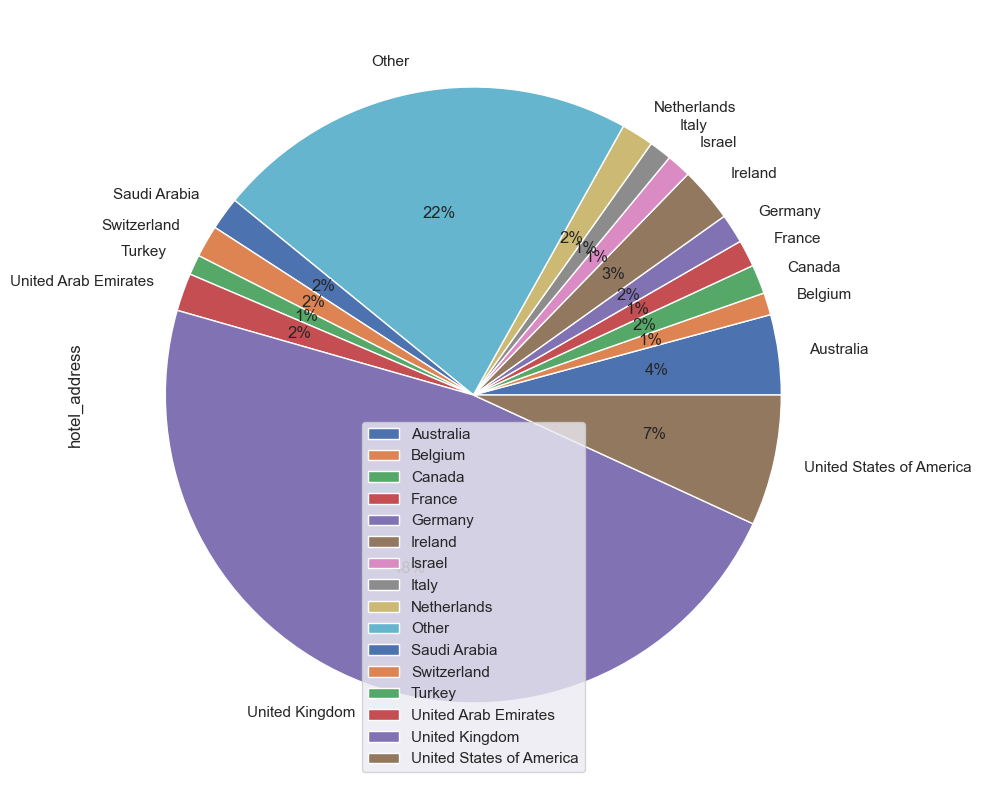

In [258]:
sns.set(font_scale = 1)
df_nationality = hotels.groupby(['reviewer_nationality']).count() 
df_nationality.plot(kind='pie', y = 'hotel_address', autopct='%1.0f%%')

Проведем визуальную оценку зависимости средней оценки от национальности рецензента.

In [259]:
# оставляем только 25 наиболее путешествующих национальностей
top_25_tourist_nations = hotels['reviewer_nationality'].value_counts().nlargest(25).index
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x:x if x in top_25_tourist_nations else 'Other')
hotels['reviewer_nationality'].value_counts(normalize=True) * 100

reviewer_nationality
United Kingdom              47.565048
Other                       22.214225
United States of America     6.866098
Australia                    4.202890
Ireland                      2.875264
United Arab Emirates         1.984747
Saudi Arabia                 1.735441
Netherlands                  1.699937
Switzerland                  1.682475
Germany                      1.539682
Canada                       1.530176
France                       1.411828
Israel                       1.281258
Italy                        1.185998
Belgium                      1.169313
Turkey                       1.055621
Name: proportion, dtype: float64

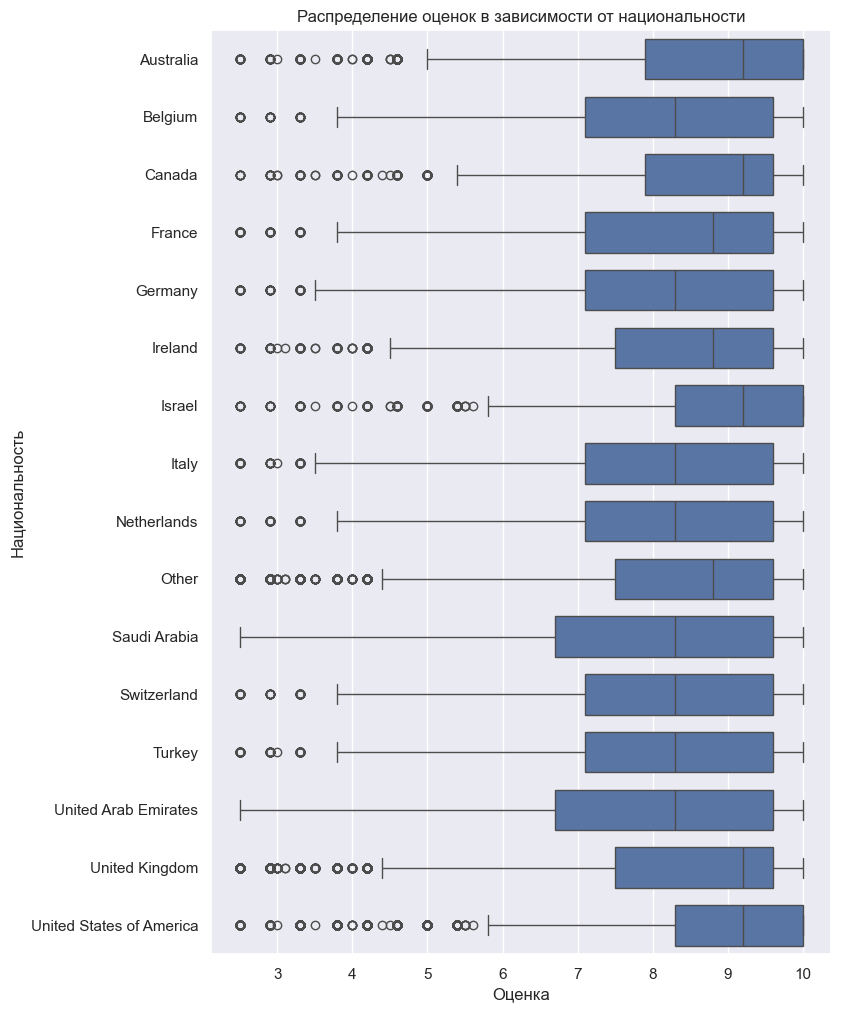

In [260]:
# посмотрим зависит ли оценка от национальности
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 12))

# строим график
nationality = sns.boxplot(data = hotels[sample_mask].sort_values(by='reviewer_nationality', ascending=True),
                          y = 'reviewer_nationality',
                          x = 'reviewer_score',orient ='h',
                          width = 0.7)

# задаём названия осей и заголовок
nationality.set(xlabel='Оценка', ylabel='Национальность', title='Распределение оценок в зависимости от национальности');

Так как есть связь между оценкой рецензента и национальностью, то применим кодирование Target Encoding, таким кодированием сформируем "веса" признака 'reviewer_nationality' в зависимости от оценки рецензента. Параметры кодировщика использованы стандартные, по умолчанию.

In [261]:
# кодируем признак
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].astype('category')
reviewer_nationality_te = ce.TargetEncoder(min_samples_leaf=20, smoothing=10).fit_transform(hotels['reviewer_nationality'], hotels['reviewer_score'])

# переименовываем признак для удобства "отсева"
reviewer_nationality_te.rename(columns={'reviewer_nationality': 'reviewer_nationality_te'}, inplace=True)
hotels = pd.concat([hotels, reviewer_nationality_te], axis=1)

# смотрим результат
hotels[['reviewer_nationality', 'reviewer_nationality_te']]

,reviewer_nationality,reviewer_nationality_te
0,United Kingdom,6.369216
1,Belgium,6.130513
2,Other,6.149463
3,United States of America,6.575431
4,United Kingdom,6.369216
...,...,...
515426,France,6.185379
515427,Turkey,6.027771
515428,Netherlands,6.127277
515429,United Arab Emirates,5.872620


# 2.7 Преобразование признака 'days_since_review'

In [262]:
# из признака 'days_since_review' выделим число, удалив слова day(s), меняем тип данных на int.
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: int(re.findall(r'\d+', x)[0])).astype('int16')

# смотрим результат
hotels['days_since_review']

0          13
1         234
2         616
3         656
4         444
         ... 
515426    106
515427    171
515428    543
515429     74
515430    363
Name: days_since_review, Length: 515431, dtype: int16

In [263]:
# сверяемся с типом признаков
hotels['days_since_review'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 515431 entries, 0 to 515430
Series name: days_since_review
Non-Null Count   Dtype
--------------   -----
515431 non-null  int16
dtypes: int16(1)
memory usage: 1006.8 KB


In [264]:
hotels['days_since_review'].max()

730

# 2.8 Преобразование признаков 'negative_review', 'positive_review'

При работе сданным признаком используем Анализ настроений с помощью SentimentIntensityAnalyzer библиотеки VADER

In [265]:
# удаляем начальные и конечные пробелы в признаке негативных отзывов
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: x.strip())
hotels['negative_review'].value_counts().reset_index().head(25)

,negative_review,count
0,No Negative,127816
1,Nothing,18525
2,nothing,2506
3,None,1166
4,N A,1060
5,,849
6,Nothing really,569
7,N a,520
8,All good,469
9,Small room,455


In [266]:
hotels['negative_review'].describe()

count          515431
unique         326566
top       No Negative
freq           127816
Name: negative_review, dtype: object

In [267]:
# удаляем начальные и конечные пробелы в признаке позитивных отзывов
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: x.strip())
hotels['positive_review'].value_counts().reset_index().head(25)

,positive_review,count
0,No Positive,35924
1,Location,10128
2,Everything,2897
3,location,1733
4,Nothing,1466
5,Great location,1417
6,The location,1339
7,Good location,1202
8,Breakfast,664
9,Friendly staff,602


In [268]:
hotels['positive_review'].describe()

count          515431
unique         407552
top       No Positive
freq            35924
Name: positive_review, dtype: object

In [269]:
%%time

# корректируем явные выражения 
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: x.replace('No Negative', 'Positive'))
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: x.replace('N A', 'Positive'))
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: x.replace('All good', 'Positive'))
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: x.replace('No complaints', 'Positive'))
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: x.replace('Nothing to dislike', 'Positive'))
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: x.replace('No Positive', 'Negative'))


CPU times: total: 641 ms
Wall time: 666 ms


In [270]:
# создаем два экземпляра анализатора, чтобы разделить лексикон 
# для разной системы оценки положительных и отрицательных отзывов
sia_neg = SentimentIntensityAnalyzer()
sia_pos = SentimentIntensityAnalyzer()

# добавим контекст, чтобы "No Negative" тонально нёс негативную окраску
neg_words = {'small': -1, 'nothing': 10}
pos_words = {'nothing': -10, 'everything': 10}
sia_neg.lexicon.update(neg_words)
sia_pos.lexicon.update(pos_words)

hotels['neg_scores'] = hotels['negative_review'].apply(lambda x: sia_neg.polarity_scores(x))
hotels['pos_scores'] = hotels['positive_review'].apply(lambda x: sia_pos.polarity_scores(x))

In [271]:
# формируем новые признаки
hotels['n_review_sentiments_neg'] = hotels['neg_scores'].apply(lambda x: x['neg'])
hotels['n_review_sentiments_neu'] = hotels['neg_scores'].apply(lambda x: x['neu'])
hotels['n_review_sentiments_pos'] = hotels['neg_scores'].apply(lambda x: x['pos'])
hotels['n_review_sentiments_compound'] = hotels['neg_scores'].apply(lambda x: x['compound'])

hotels['p_review_sentiments_neg'] = hotels['pos_scores'].apply(lambda x: x['neg'])
hotels['p_review_sentiments_neu'] = hotels['pos_scores'].apply(lambda x: x['neu'])
hotels['p_review_sentiments_pos'] = hotels['pos_scores'].apply(lambda x: x['pos'])
hotels['p_review_sentiments_compound'] = hotels['pos_scores'].apply(lambda x: x['compound'])

# сверяемся с типом признаков
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 70 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515431 non-null  object        
 1   additional_number_of_scoring                515431 non-null  int64         
 2   review_date                                 515431 non-null  datetime64[ns]
 3   average_score                               515431 non-null  float64       
 4   hotel_name                                  515431 non-null  category      
 5   reviewer_nationality                        515431 non-null  category      
 6   negative_review                             515431 non-null  object        
 7   review_total_negative_word_counts           515431 non-null  int64         
 8   total_number_of_reviews                     515431 non-null  int64        

# 2.9 Преобразование признаков 'review_total_negative_word_counts', 'review_total_positive_word_counts'

Целевая переменная демонстрирует зависимость от обеих величин. Соединим оба признака в один, вычислив разницу количества слов в позитивной и негативной частях отзыва, предварительно нормализуем оба признака

In [272]:
# кодируем исходный признак
hotels_ttl_pos_words_cnts_mm = preprocessing.MinMaxScaler().fit_transform(hotels[['review_total_positive_word_counts']])
hotels_ttl_neg_words_cnts_mm = preprocessing.MinMaxScaler().fit_transform(hotels[['review_total_negative_word_counts']])

# преобразуем промежуточный датасет в полноценный датафрейм для визуализации
hotels_ttl_pos_words_cnts_mm = pd.DataFrame(hotels_ttl_pos_words_cnts_mm, columns=['review_ttl_pos_word_cnts_norm'])
hotels_ttl_neg_words_cnts_mm = pd.DataFrame(hotels_ttl_neg_words_cnts_mm, columns=['review_ttl_neg_word_cnts_norm'])

# добавляем к основному датасету
hotels = pd.concat([hotels, hotels_ttl_pos_words_cnts_mm], axis=1)
hotels = pd.concat([hotels, hotels_ttl_neg_words_cnts_mm], axis=1)

# соединим эти показатели в один - разностный
hotels['review_ttl_word_cnts_diff_norm'] = hotels['review_ttl_pos_word_cnts_norm'] - hotels['review_ttl_neg_word_cnts_norm']

# добавим флаг, который показывает преобладают ли позитивные слова 
# над негативными в размерностях соответствующих диапазонов
hotels['more_positive_words_flag'] = hotels['review_ttl_word_cnts_diff_norm'].apply(lambda x: 1 if x >= 0 else 0).astype('int8')

Также добавим долю одной из частей (второй показатель будет обратно пропорциональным)

In [273]:
# формируем новый дополнительный признак из числа основных
hotels['review_total_word_counts'] = hotels['review_total_positive_word_counts'] + hotels['review_total_negative_word_counts']

# если общее количество слов равно 0, то считаем обе части равнозначными - по 0.5
hotels['review_positive_word_proportion'] = hotels.apply( lambda x: 0.5 if x['review_total_word_counts'] == 0 \
    else (x['review_total_positive_word_counts'] / x['review_total_word_counts']), axis=1)

# удаление вспомогательных дополнительных признаков
hotels.drop(['review_ttl_pos_word_cnts_norm', 
    'review_ttl_neg_word_cnts_norm', 
    'review_ttl_word_cnts_diff_norm',
    'review_total_word_counts'], axis = 1, inplace=True)

In [274]:
# проверка результата
hotels[['more_positive_words_flag', 'review_positive_word_proportion']]

,more_positive_words_flag,review_positive_word_proportion
0,1,0.543860
1,0,0.000000
2,1,0.625000
3,1,1.000000
4,1,1.000000
...,...,...
515426,1,1.000000
515427,1,1.000000
515428,0,0.428571
515429,1,1.000000


# 2.10 Преобразование признака 'total_number_of_reviews_reviewer_has_given'

In [275]:
# вычисляем долю рецензий данных рецензентом от общего числа отзывов в датасете
hotels['ratio_of_review'] = hotels['total_number_of_reviews_reviewer_has_given'] / hotels['total_number_of_reviews']

# логарифмируем значение признака, чтобы оставить только информацию о степени (порядке) активности рецензента
hotels['total_number_of_reviews_reviewer_has_given'] = hotels['total_number_of_reviews_reviewer_has_given'].apply(lambda x: np.log(x + 1))

# проверка результата
hotels['ratio_of_review']

0         0.000060
1         0.001395
2         0.042735
3         0.005833
4         0.000427
            ...   
515426    0.016207
515427    0.000310
515428    0.007634
515429    0.017869
515430    0.001654
Name: ratio_of_review, Length: 515431, dtype: float64

## 3. Очистка и выбор признаков

Подготовим датасет к очистке признаков, на которых модель обучаться не будет.

# 3.1 Очистка датасета от исходных (и более не требующихся) признаков

In [276]:
# сверяемся с типом признаков
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 73 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515431 non-null  object        
 1   additional_number_of_scoring                515431 non-null  int64         
 2   review_date                                 515431 non-null  datetime64[ns]
 3   average_score                               515431 non-null  float64       
 4   hotel_name                                  515431 non-null  category      
 5   reviewer_nationality                        515431 non-null  category      
 6   negative_review                             515431 non-null  object        
 7   review_total_negative_word_counts           515431 non-null  int64         
 8   total_number_of_reviews                     515431 non-null  int64        

In [277]:
# создаем копию датафрейма (для повторного воспроизведения шагов с уже обработанными данными)
df_copy = hotels.__deepcopy__()

# страхуемся
# hotels = df_copy

In [278]:
# убираем нечисловые признаки, т.к. модель может обучаться только на числовых признаках
object_columns = [col for col in hotels.columns
    if ((hotels[col].dtypes == 'object') | \
        (hotels[col].dtype.name == 'category') | \
        (hotels[col].dtypes == 'datetime64[ns]'))]

# смотрим результат 
print(f'Удалению подлежит {len(object_columns)} столбцов с нечисловыми данными:')
object_columns

Удалению подлежит 16 столбцов с нечисловыми данными:


['hotel_address',
 'review_date',
 'hotel_name',
 'reviewer_nationality',
 'negative_review',
 'positive_review',
 'tags',
 'hotel_country',
 'tags_new',
 'trip',
 'guest_stat',
 'night_quantity',
 'rooms',
 'year_month',
 'neg_scores',
 'pos_scores']

In [279]:
# удаляем выбранные признаки по заданным критериям
hotels.drop(object_columns, axis = 1, inplace=True)
hotels = hotels.drop(['days_since_review'], axis = 1)

In [280]:
# сверяемся с типом признаков
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 56 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   review_total_negative_word_counts           515431 non-null  int64  
 3   total_number_of_reviews                     515431 non-null  int64  
 4   review_total_positive_word_counts           515431 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515431 non-null  float64
 6   lat                                         515431 non-null  float64
 7   lng                                         515431 non-null  float64
 8   sample                                      515431 non-null  int64  
 9   reviewer_score                              515431 non-null  float64
 

# 3.2 Анализ мультиколлинеарности

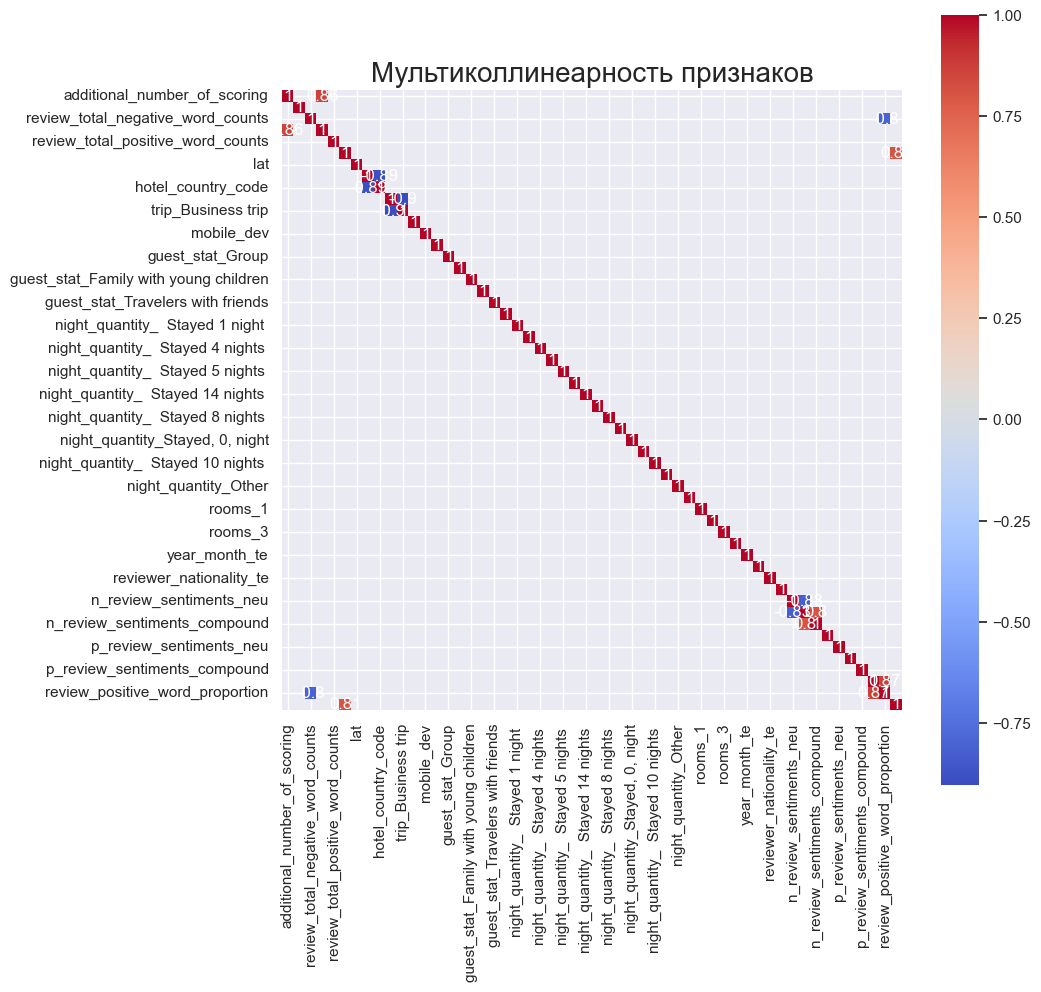

In [281]:
# посмотрим корреляционную матрицу и анализируем данные на предмет мультиколлинеарности
corr = hotels.drop(['sample', 'reviewer_score'], axis=1).corr( numeric_only = True, method='spearman')
plt.subplots(figsize=(10, 10))

# график - тепловая матрица с коэффициентами корреляции не менее 0.7
ax_heat_multicoll = sns.heatmap(corr[corr.abs() >= 0.7],
                                cmap='coolwarm',
                                square=True,
                                annot = True)

# задаём заголовок
ax_heat_multicoll.set_title('Мультиколлинеарность признаков', fontsize=20);

Удалим признаки с коэффициентом корреляции больше 0.65

In [282]:
hotels = hotels.drop(['lat','lng', 'trip_Business trip'], axis = 1)

In [283]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 53 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   review_total_negative_word_counts           515431 non-null  int64  
 3   total_number_of_reviews                     515431 non-null  int64  
 4   review_total_positive_word_counts           515431 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515431 non-null  float64
 6   sample                                      515431 non-null  int64  
 7   reviewer_score                              515431 non-null  float64
 8   hotel_country_code                          515431 non-null  int8   
 9   trip_Leisure trip                           515431 non-null  int64  
 

# 3.3 Оценка значимости признаков

Для оценки значимости признаков будем использовать тесты:
- хи-квадрат - для категориальных
- тест ANOVA - для числовых (непрерывных) признаков

In [284]:
# разделим признаки на 2 группы - категориальные и числовые
hotels.columns

Index(['additional_number_of_scoring', 'average_score',
       'review_total_negative_word_counts', 'total_number_of_reviews',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'sample',
       'reviewer_score', 'hotel_country_code', 'trip_Leisure trip',
       'trip_Not a trip', 'mobile_dev', 'guest_stat_Couple',
       'guest_stat_Group', 'guest_stat_Solo traveler',
       'guest_stat_Family with young children',
       'guest_stat_Family with older children',
       'guest_stat_Travelers with friends',
       'night_quantity_  Stayed 2 nights ', 'night_quantity_  Stayed 1 night ',
       'night_quantity_  Stayed 3 nights ',
       'night_quantity_  Stayed 4 nights ',
       'night_quantity_  Stayed 7 nights ',
       'night_quantity_  Stayed 5 nights ',
       'night_quantity_  Stayed 6 nights ',
       'night_quantity_  Stayed 14 nights ',
       'night_quantity_  Stayed 12 nights ',
       'night_quantity_  Stayed 8 nights ',
       '

In [285]:
# категориальные признаки
cat_cols = ['hotel_country_code', 'trip_Leisure trip', 'trip_Not a trip', 
            'mobile_dev', 'guest_stat_Couple', 'guest_stat_Group', 
            'guest_stat_Solo traveler',
            'guest_stat_Family with young children',
            'guest_stat_Family with older children',
            'guest_stat_Travelers with friends',
            'night_quantity_  Stayed 2 nights ', 
            'night_quantity_  Stayed 1 night ',
            'night_quantity_  Stayed 3 nights ',
            'night_quantity_  Stayed 4 nights ',
            'night_quantity_  Stayed 7 nights ',
            'night_quantity_  Stayed 5 nights ',
            'night_quantity_  Stayed 6 nights ',
            'night_quantity_  Stayed 14 nights ',
            'night_quantity_  Stayed 12 nights ',
            'night_quantity_  Stayed 8 nights ',
            'night_quantity_  Stayed 9 nights ', 
            'night_quantity_Stayed, 0, night',
            'night_quantity_  Stayed 13 nights ',
            'night_quantity_  Stayed 10 nights ',
            'night_quantity_  Stayed 11 nights ',
            'night_quantity_Other','rooms_0', 'rooms_1',
            'rooms_2','rooms_3', 'rooms_4', 'hotel_name_code',
            'reviewer_nationality_te', 'more_positive_words_flag']

# числовые (непрерывные) признаки
num_cols = ['additional_number_of_scoring', 'average_score', 
            'review_total_negative_word_counts', 
            'total_number_of_reviews', 
            'review_total_positive_word_counts', 
            'total_number_of_reviews_reviewer_has_given', 
            'n_review_sentiments_neu', 'n_review_sentiments_neg',
            'n_review_sentiments_pos', 'n_review_sentiments_compound', 
            'p_review_sentiments_neg', 'p_review_sentiments_neu', 
            'p_review_sentiments_pos', 'p_review_sentiments_compound',
            'review_positive_word_proportion', 'ratio_of_review']

In [286]:
# разбиваем датасет на части, необходимые для оценки признаков
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)
X = hotels[sample_mask].drop(['reviewer_score'], axis = 1)
y = hotels[sample_mask]['reviewer_score'].astype('int')

In [289]:
# функция построения тепловой матрицы корреляции для группы признаков
def show_corr_heatmap(columns_list, method='pearson', title_heat=None):
    """ Функция строит тепловую матрицу корреляции по переданным параметрам,
        на выходе - график, никакие значения не возвращаются

    Args:
        columns_list (list): список признаков, для которых строится матрица корреляции
        method (str, optional): расчётный метод корреляции. Defaults to 'pearson'.
        title_heat (str, optional): заголовок графика. Defaults to None.
    """
    _, ax_heat = plt.subplots(figsize=(15, 15))
    # данные для построения графика
    corr = hotels[columns_list].corr(method=method)
    
    # задаём срезовую маску, выводятся параметры по нижней диагонали
    mask = np.triu(np.ones_like(corr, dtype=bool))
    
    # график - тепловая матрица
    sns.heatmap(corr,
                ax=ax_heat,
                vmin=-1, 
                vmax=1, 
                mask=mask,
                linewidths=0.1,
                annot=True,
                cmap='coolwarm',
                fmt='.2f',
                square=True)
    
    # задаём заголовок и кегль начертания
    ax_heat.set_title(title_heat, fontsize=20)
    plt.show()

# Оценка значимости категориальных признаков


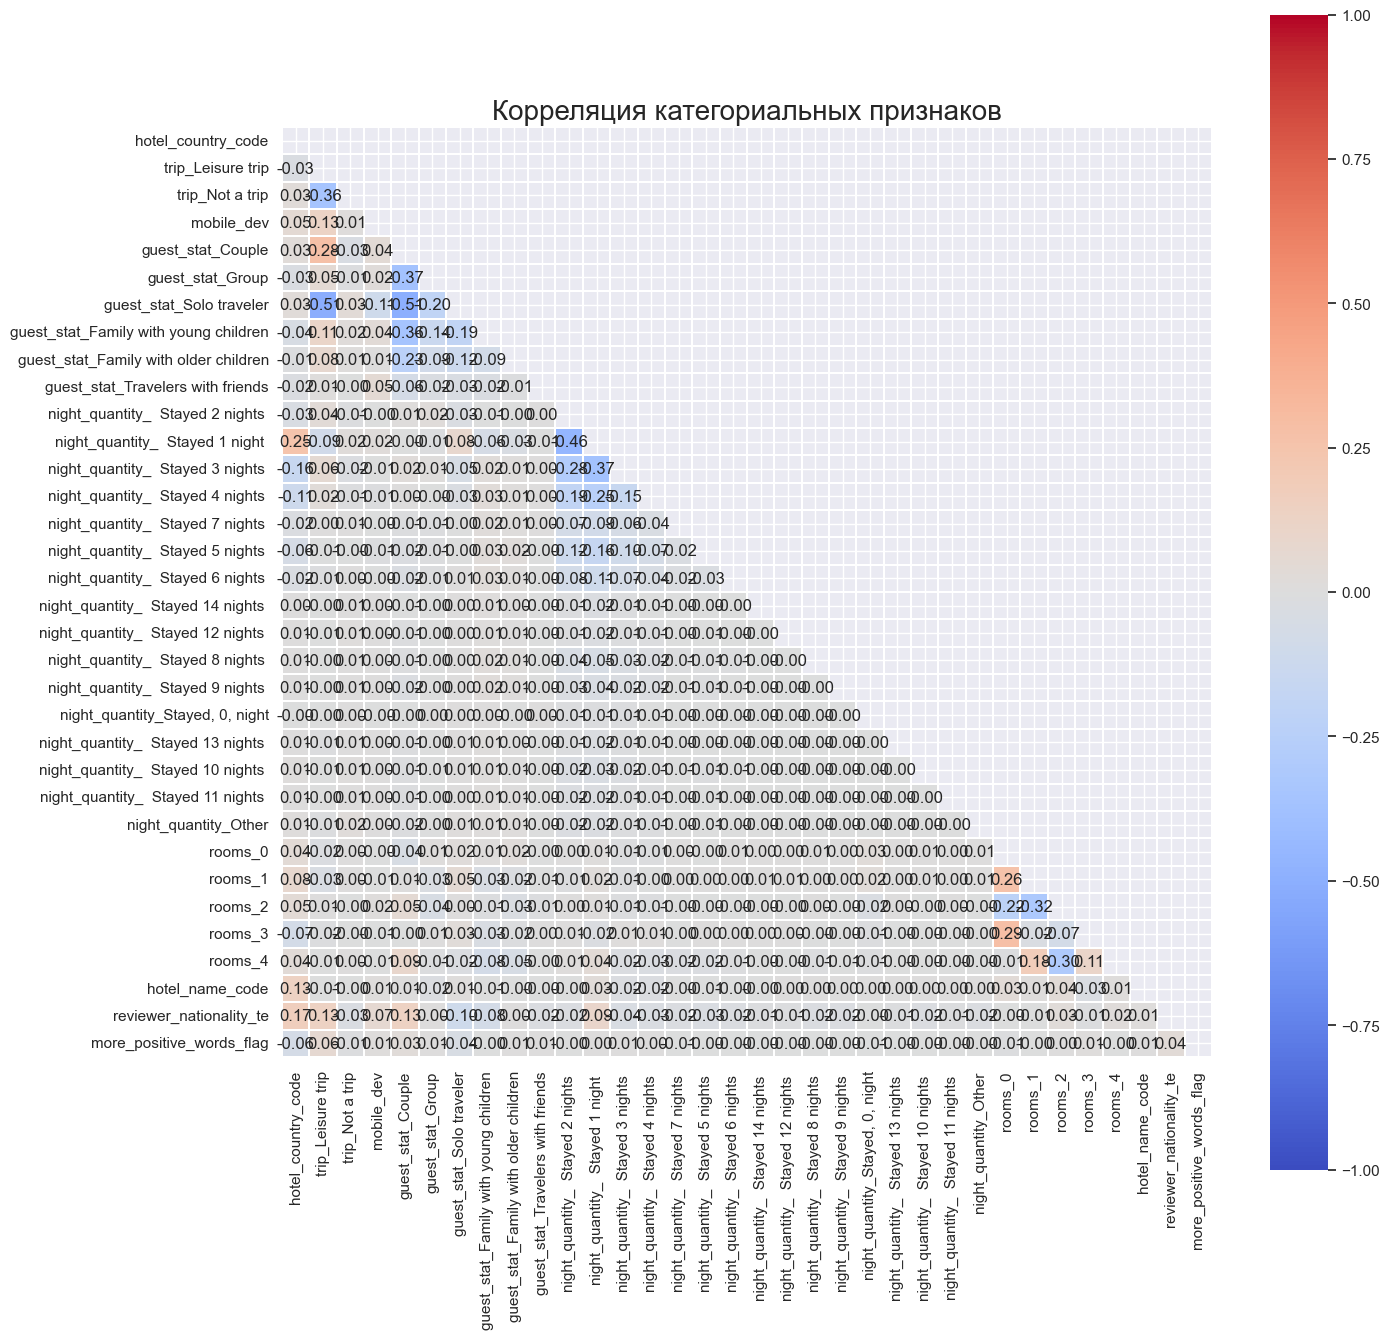

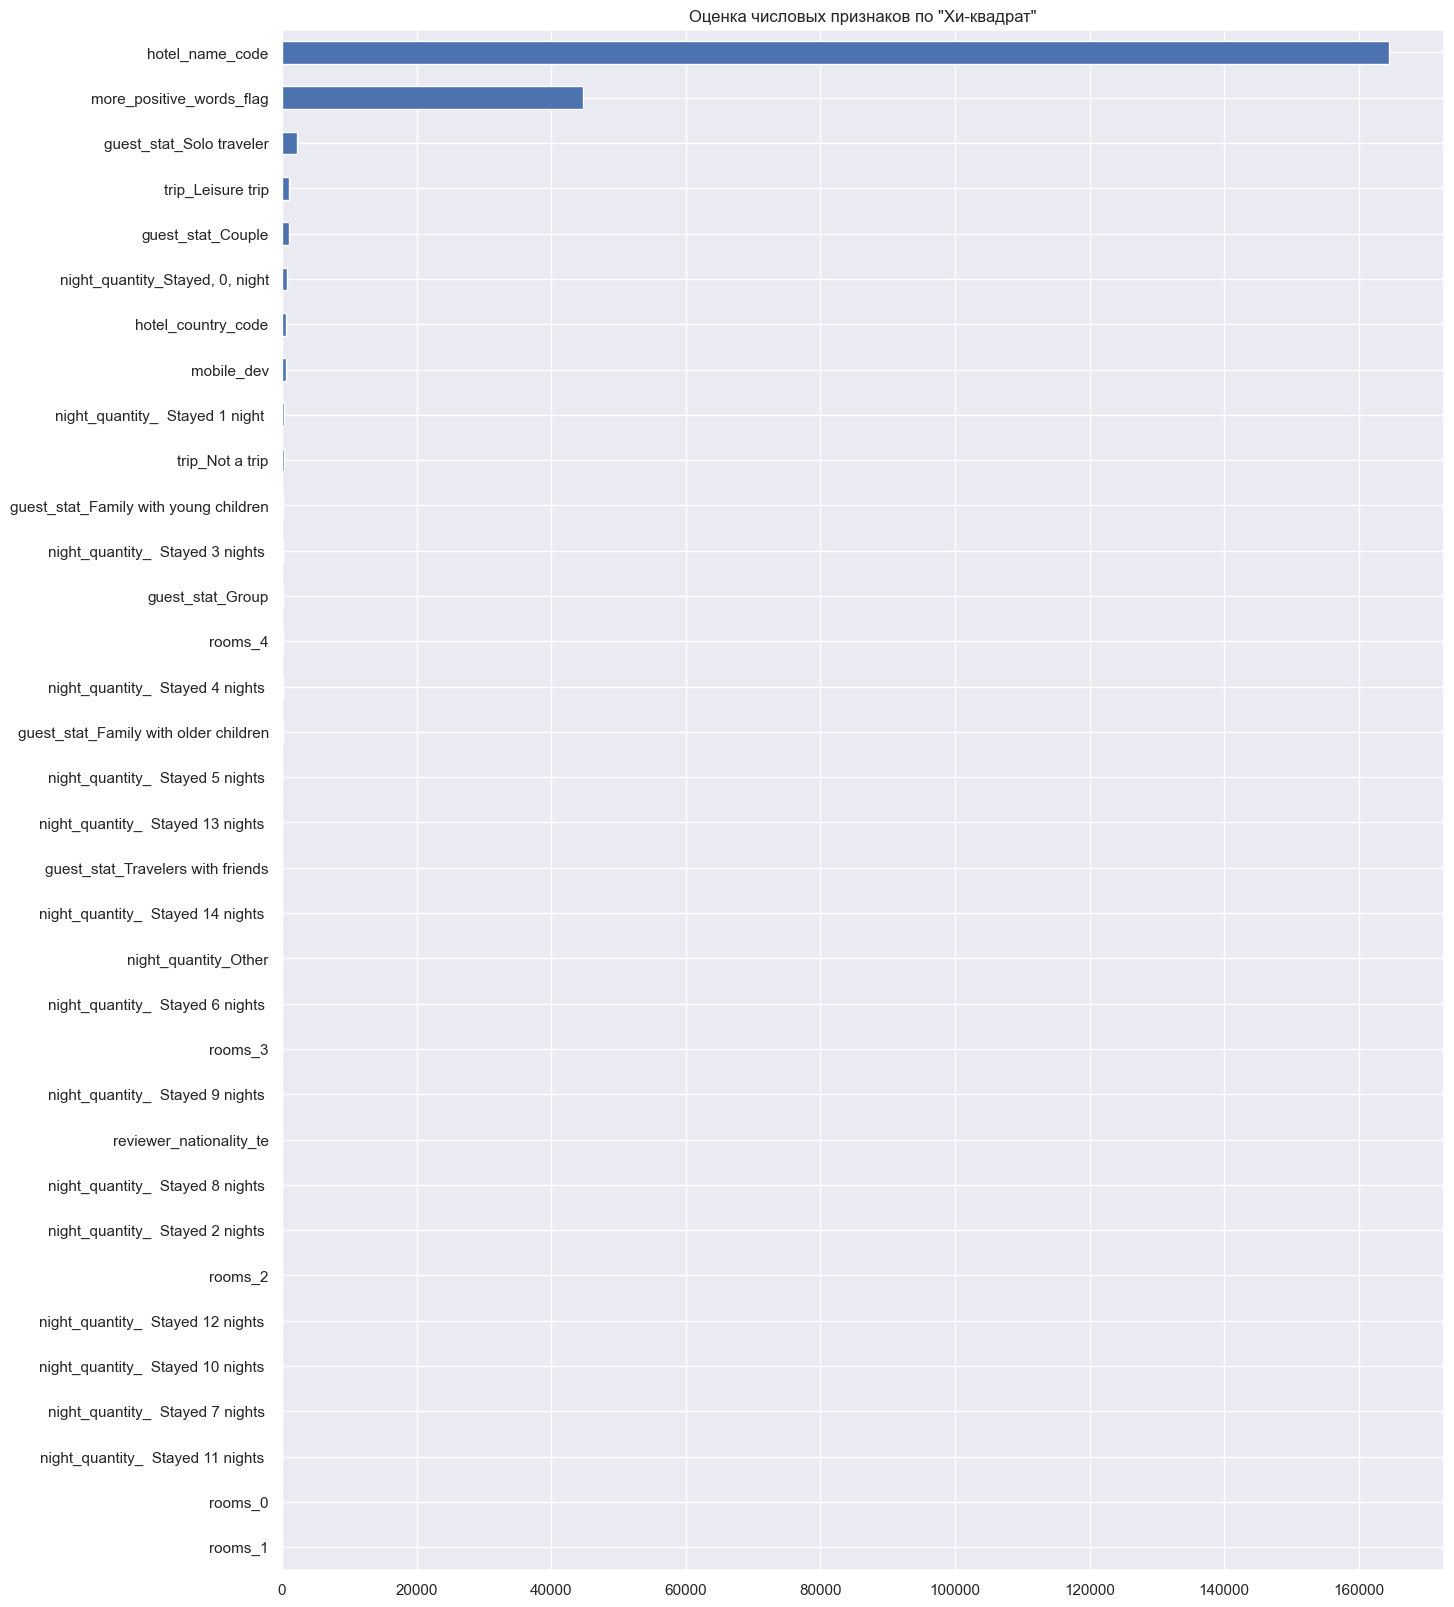

In [290]:
# графики категориальных признаков

# тепловая матрица категориальных признаков
show_corr_heatmap(cat_cols, 
                  method='spearman',
                  title_heat='Корреляция категориальных признаков')

# визуализируем результат анализа значимости
# столбчатая диаграмма категориальных признаков по "хи-квадрат"
imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index = cat_cols)
imp_cat.sort_values(inplace = True)
_, ax_barh_chi2 = plt.subplots(figsize=(15, 20))
imp_cat.plot(kind = 'barh', title='Оценка числовых признаков по "Хи-квадрат"');

In [291]:
imp_cat

rooms_1                                      10.337010
rooms_0                                      11.860519
night_quantity_  Stayed 11 nights            19.121007
night_quantity_  Stayed 7 nights             20.784642
night_quantity_  Stayed 10 nights            22.839741
night_quantity_  Stayed 12 nights            22.964791
rooms_2                                      25.925023
night_quantity_  Stayed 2 nights             26.409217
night_quantity_  Stayed 8 nights             28.012055
reviewer_nationality_te                      28.085750
night_quantity_  Stayed 9 nights             29.249343
rooms_3                                      31.715220
night_quantity_  Stayed 6 nights             33.523394
night_quantity_Other                         37.826708
night_quantity_  Stayed 14 nights            40.414083
guest_stat_Travelers with friends            43.006544
night_quantity_  Stayed 13 nights            43.711183
night_quantity_  Stayed 5 nights             73.088959
guest_stat

# Оценка значимости числовых признаков

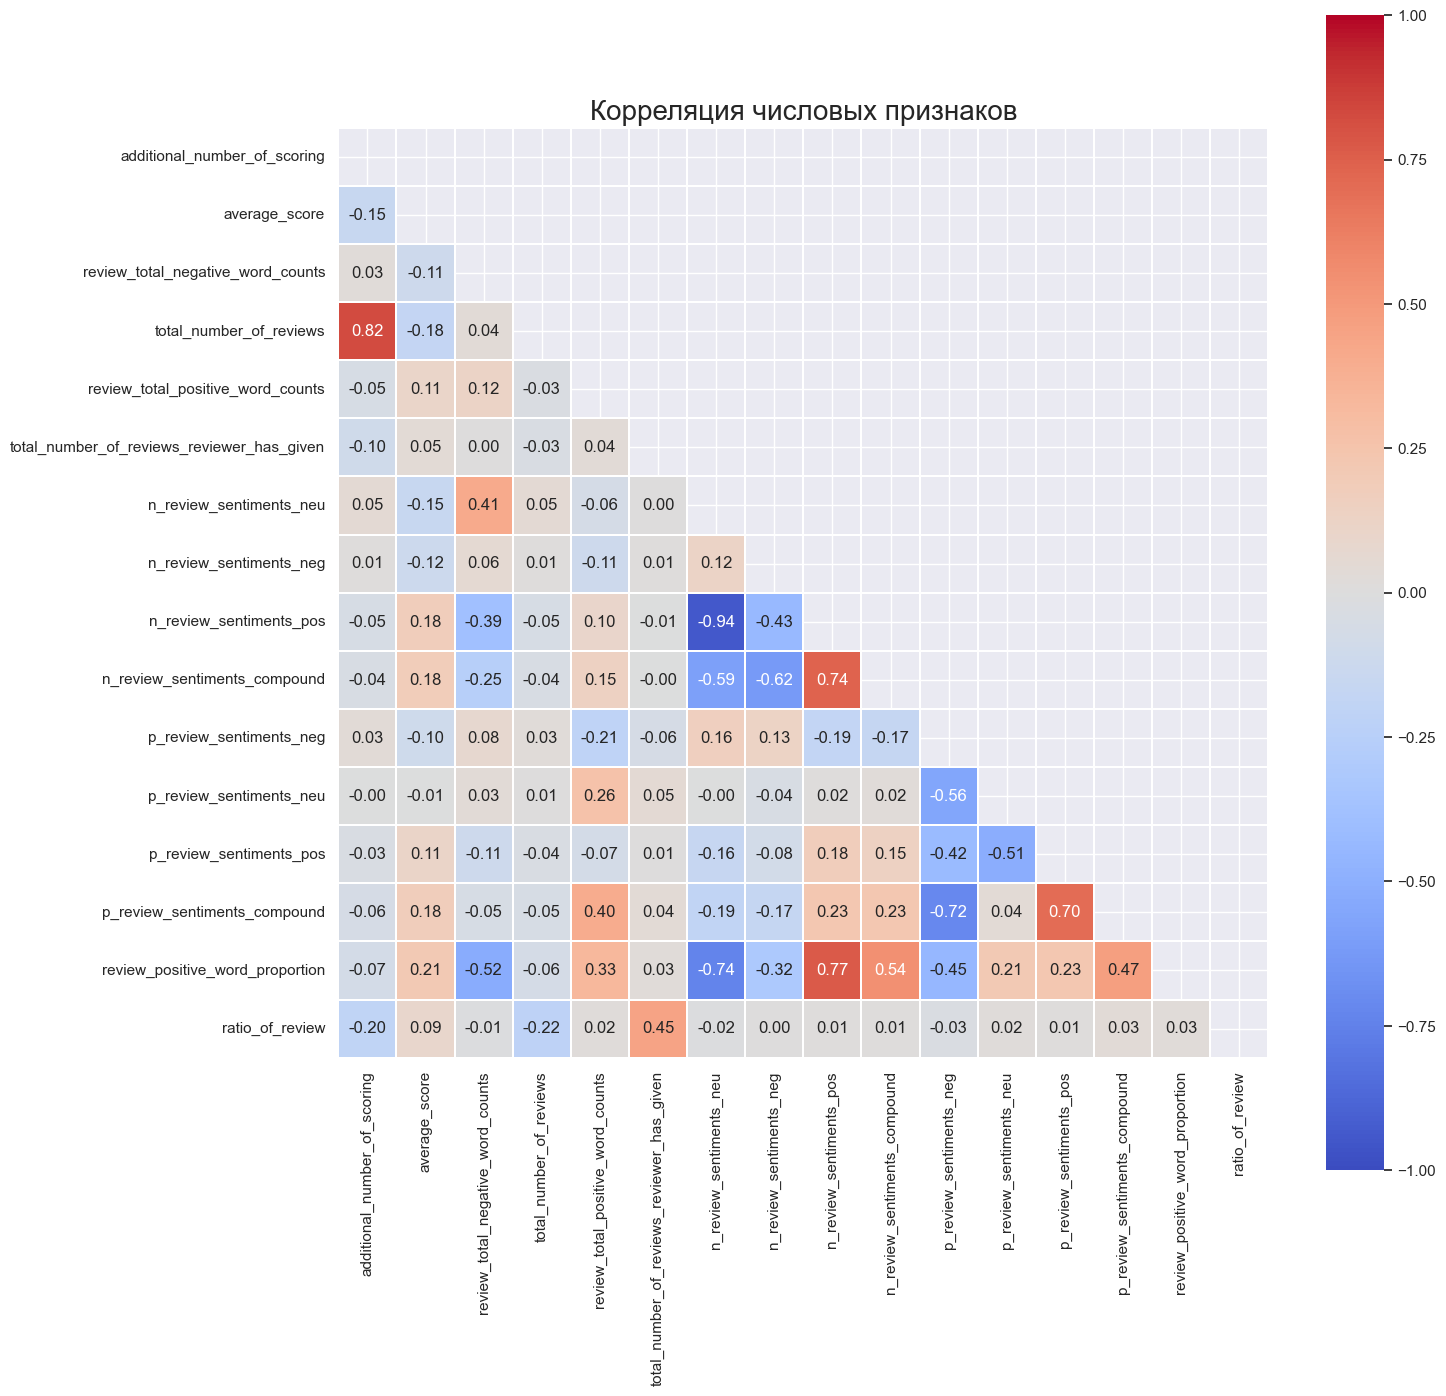

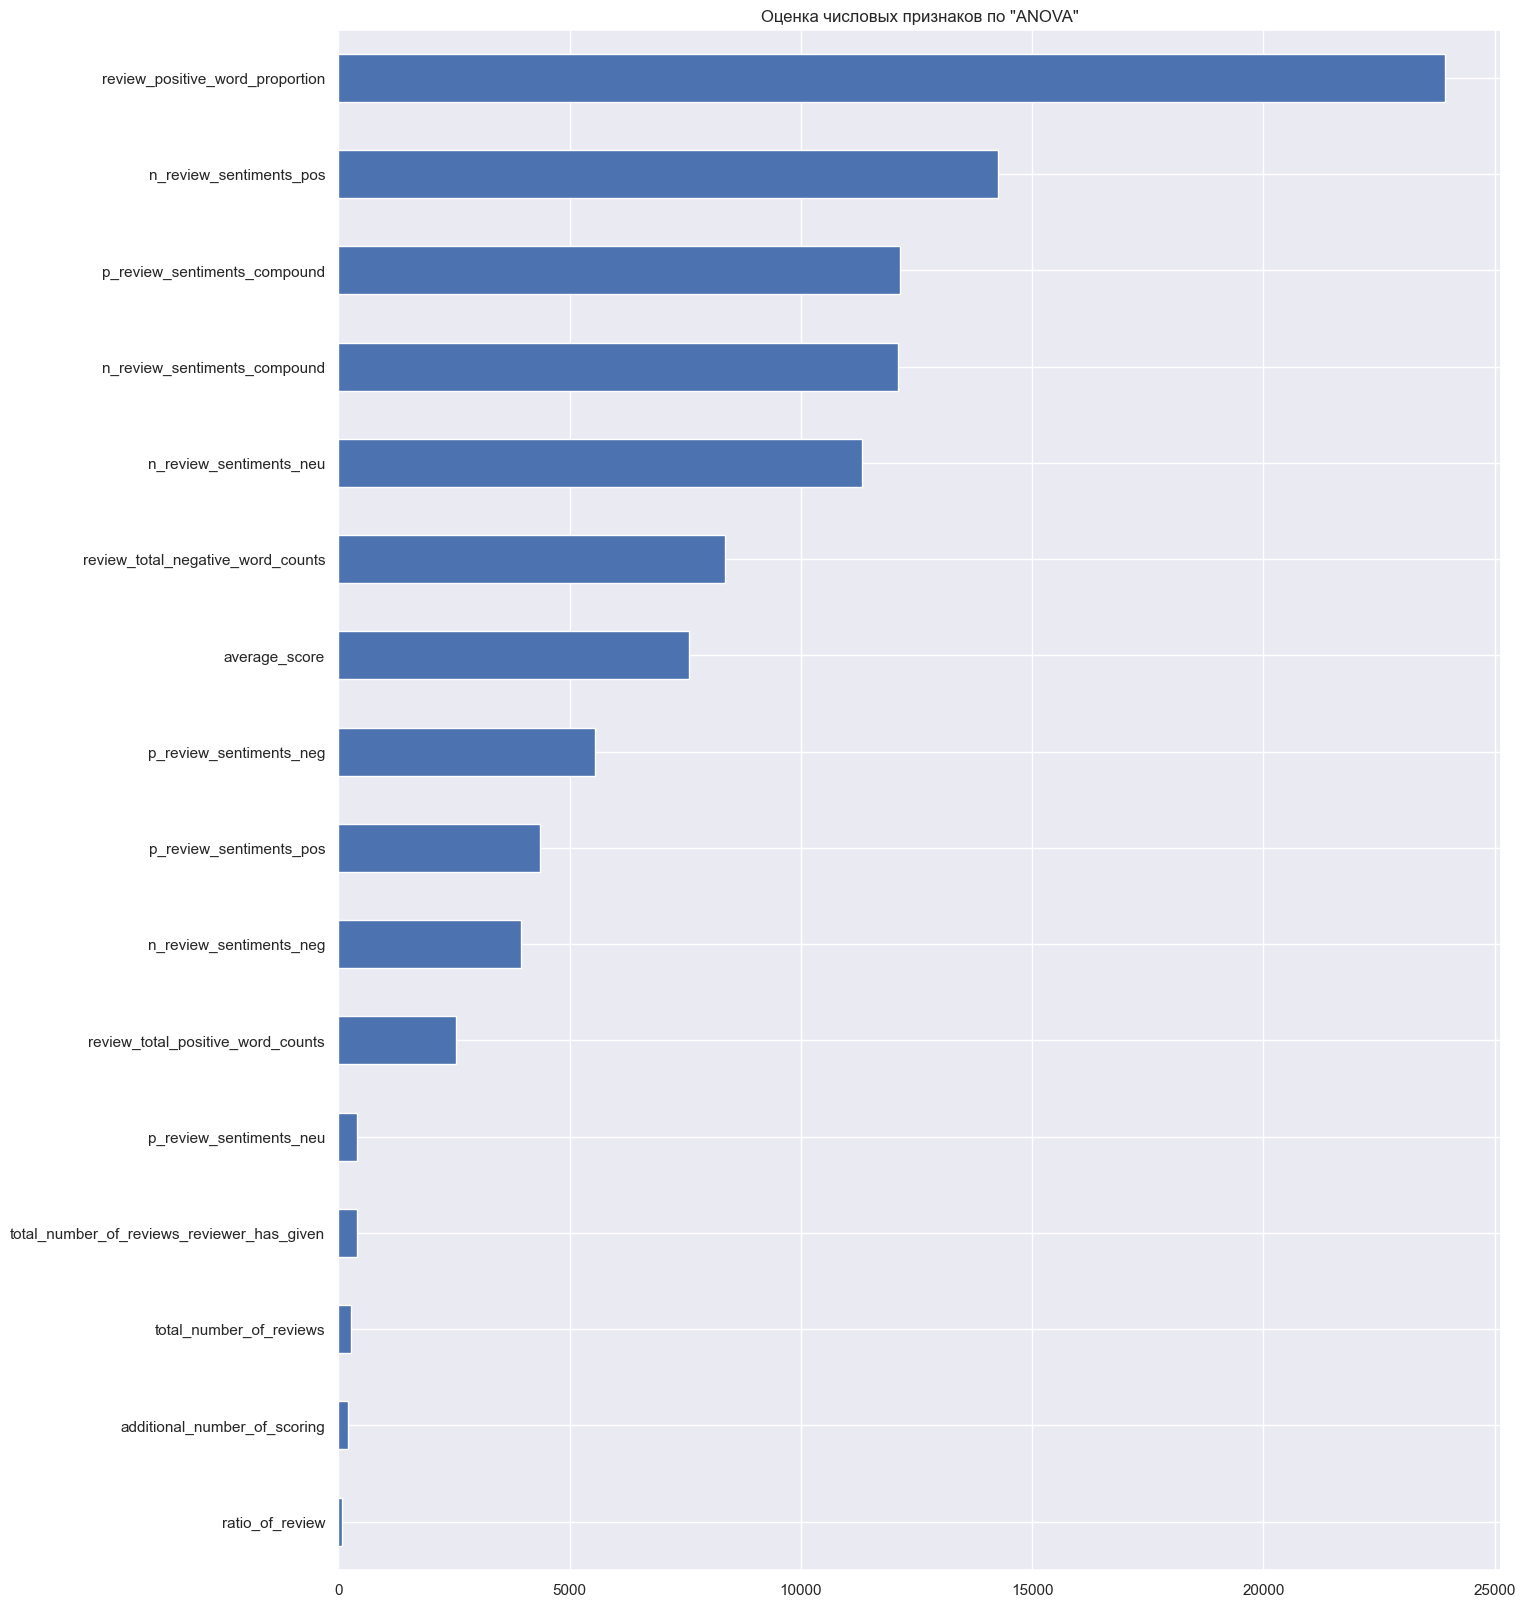

In [292]:
# графики числовых признаков

# тепловая матрица числовых признаков
show_corr_heatmap(num_cols,
                  method='pearson',
                  title_heat='Корреляция числовых признаков')

# визуализируем результат анализа значимости
# столбчатая диаграмма категориальных признаков по ANOVA
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
_, ax_barh_anova = plt.subplots(figsize=(15, 20))
imp_num.plot(kind = 'barh', title='Оценка числовых признаков по "ANOVA"');

In [293]:
imp_num

ratio_of_review                                  83.579671
additional_number_of_scoring                    212.164084
total_number_of_reviews                         277.930171
total_number_of_reviews_reviewer_has_given      401.009049
p_review_sentiments_neu                         404.962285
review_total_positive_word_counts              2550.332232
n_review_sentiments_neg                        3954.199019
p_review_sentiments_pos                        4369.981776
p_review_sentiments_neg                        5539.825218
average_score                                  7588.683414
review_total_negative_word_counts              8366.065720
n_review_sentiments_neu                       11330.034849
n_review_sentiments_compound                  12108.464911
p_review_sentiments_compound                  12140.604132
n_review_sentiments_pos                       14259.149822
review_positive_word_proportion               23936.442421
dtype: float64

Удаляем признаки с самой низкой значимостью.

In [294]:
# признаки к удалению
drop_df = ['ratio_of_review', 'additional_number_of_scoring','total_number_of_reviews', 'rooms_1', 'rooms_0', 
           'night_quantity_  Stayed 7 nights ','night_quantity_  Stayed 10 nights ', 
           'rooms_2', 'night_quantity_  Stayed 2 nights ', 'night_quantity_  Stayed 8 nights ',
           'reviewer_nationality_te',  'rooms_3']
hotels.drop(drop_df, axis = 1, inplace=True)

## 4. Обучение модели

In [295]:
train_hotels = hotels[hotels['sample'] == 1].drop(['sample'], axis=1)
test_hotels = hotels[hotels['sample'] == 0].drop(['sample'], axis=1)

X = train_hotels.drop(['reviewer_score'], axis=1)
y = train_hotels['reviewer_score'].values

# Обучения модели с помощью модуля RandomForestRegressor

In [296]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 20% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_SEED)

In [297]:
# проверяем
test_hotels.shape, train_hotels.shape, X.shape, X_train.shape, X_test.shape

((128935, 40), (386496, 40), (386496, 39), (309196, 39), (77300, 39))

In [298]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [299]:
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   43.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.6s finished


In [300]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12079288542186639


<Axes: >

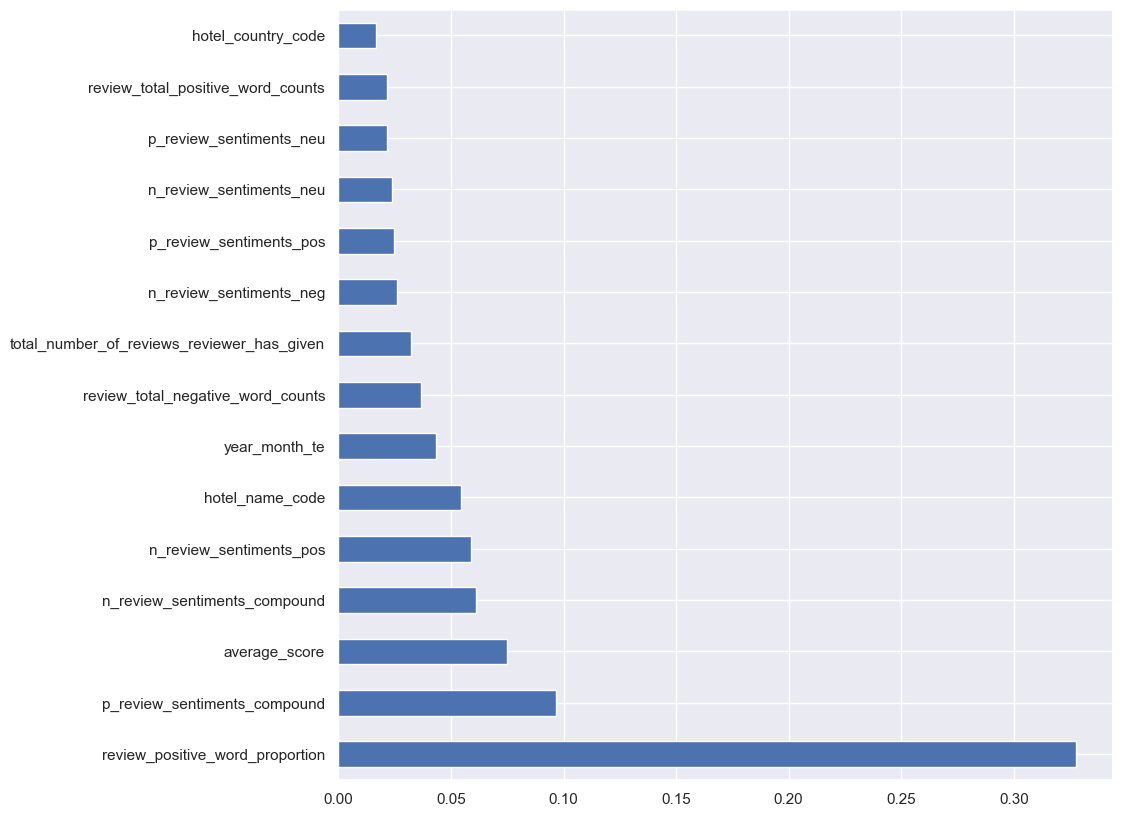

In [301]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [302]:
test_hotels.sample(10)

,average_score,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,hotel_country_code,trip_Leisure trip,trip_Not a trip,mobile_dev,guest_stat_Couple,...,n_review_sentiments_neg,n_review_sentiments_neu,n_review_sentiments_pos,n_review_sentiments_compound,p_review_sentiments_neg,p_review_sentiments_neu,p_review_sentiments_pos,p_review_sentiments_compound,more_positive_words_flag,review_positive_word_proportion
67125,8.4,7,57,1.609438,0.0,3,1,0,0,0,...,0.000,1.000,0.000,0.0000,0.000,0.725,0.275,0.9360,1,0.890625
5701,7.7,5,4,3.178054,0.0,5,0,0,0,0,...,0.500,0.500,0.000,-0.2500,0.000,0.408,0.592,0.4404,0,0.444444
61519,8.1,9,16,2.397895,0.0,1,1,0,1,1,...,0.000,1.000,0.000,0.0000,0.000,0.635,0.365,0.7837,1,0.640000
62126,8.9,71,27,2.079442,0.0,5,1,0,1,1,...,0.083,0.917,0.000,-0.5187,0.000,0.710,0.290,0.8221,0,0.275510
18836,9.0,8,22,0.693147,0.0,5,1,0,0,1,...,0.556,0.444,0.000,-0.6133,0.000,0.746,0.254,0.6997,1,0.733333
17243,9.0,0,13,0.693147,0.0,5,1,0,0,1,...,0.000,0.000,1.000,0.5574,0.000,0.455,0.545,0.8955,1,1.000000
16059,8.1,0,9,0.693147,0.0,5,1,0,1,1,...,0.000,0.000,1.000,0.5574,0.000,0.690,0.310,0.4019,1,1.000000
89816,7.5,5,20,1.098612,0.0,1,1,0,1,0,...,0.000,0.444,0.556,0.3612,0.000,0.722,0.278,0.6124,1,0.800000
112928,8.5,16,22,1.791759,0.0,3,1,0,0,0,...,0.000,0.354,0.646,0.9607,0.000,0.591,0.409,0.8860,1,0.578947
23789,8.5,0,103,1.098612,0.0,5,1,0,0,1,...,0.000,0.000,1.000,0.5574,0.029,0.783,0.188,0.9612,1,1.000000


In [303]:
# предсказание целевой переменной
test_hotels = test_hotels.drop(['reviewer_score'], axis=1)

In [304]:
predict_submission = regr.predict(test_hotels)
predict_submission

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.0s finished


array([8.651, 7.195, 7.957, ..., 7.963, 9.446, 7.452])

In [305]:
sample_submission

,reviewer_score,id
0,8.651,488440
1,7.195,274649
2,7.957,374688
3,9.750,404352
4,9.512,451596
...,...,...
128930,9.136,495812
128931,9.611,315577
128932,7.963,511968
128933,9.446,303386


In [306]:
list(sample_submission)

['reviewer_score', 'id']

In [307]:
sample_submission['reviewer_score'] = predict_submission

In [308]:
# сохрание результата (сабмишн для загрузки и оценки)
sample_submission.to_csv(INPUT_DIR + 'submission.csv', index=False)

# Результат
sample_submission.head(10)

,reviewer_score,id
0,8.651,488440
1,7.195,274649
2,7.957,374688
3,9.750,404352
4,9.512,451596
5,9.130,302161
6,8.179,317079
7,7.642,13963
8,8.637,159785
9,7.492,195089
